## Read in Train, Val, Test

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import timm  # Vision Transformer
import sentence_transformers
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
from sentence_transformers import SentenceTransformer
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import timm  # Vision Transformer
!pip install grad-cam --quiet
import torch
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.reshape_transforms import vit_reshape_transform
from transformers import CLIPProcessor, CLIPModel
import kagglehub
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import re

# cnn model
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
import time

In [ ]:
# Download latest version
path = kagglehub.dataset_download("ubitquitin/geolocation-geoguessr-images-50k")

print("Path to dataset files:", path)

100%|██████████| 6.66G/6.66G [04:02<00:00, 29.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ubitquitin/geolocation-geoguessr-images-50k/versions/1


In [4]:
train_df = pd.read_csv('train_dataset.csv')
val_df = pd.read_csv('val_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

In [ ]:
train_df.head()

img_path                country  \
0  geoguessr_data/compressed_dataset/Russia/canva...                 Russia   
1  geoguessr_data/compressed_dataset/Ireland/canv...  Other countries in EU   
2  geoguessr_data/compressed_dataset/Thailand/can...               Thailand   
3  geoguessr_data/compressed_dataset/Spain/canvas...                  Spain   
4  geoguessr_data/compressed_dataset/Germany/canv...                Germany   

  continent  
0        EU  
1        EU  
2        AS  
3        EU  
4        EU

The train, val, and test splits have already been done (I did these in vscode; the csv files simply have the file paths to each of the images)

If a country had less than 400 images, then it was grouped into a category called "Other countries in {continent}."

# EDA
## 1) Visualizing count of images per country
- U.S. has nearly 25% of observations -- very imbalanced.

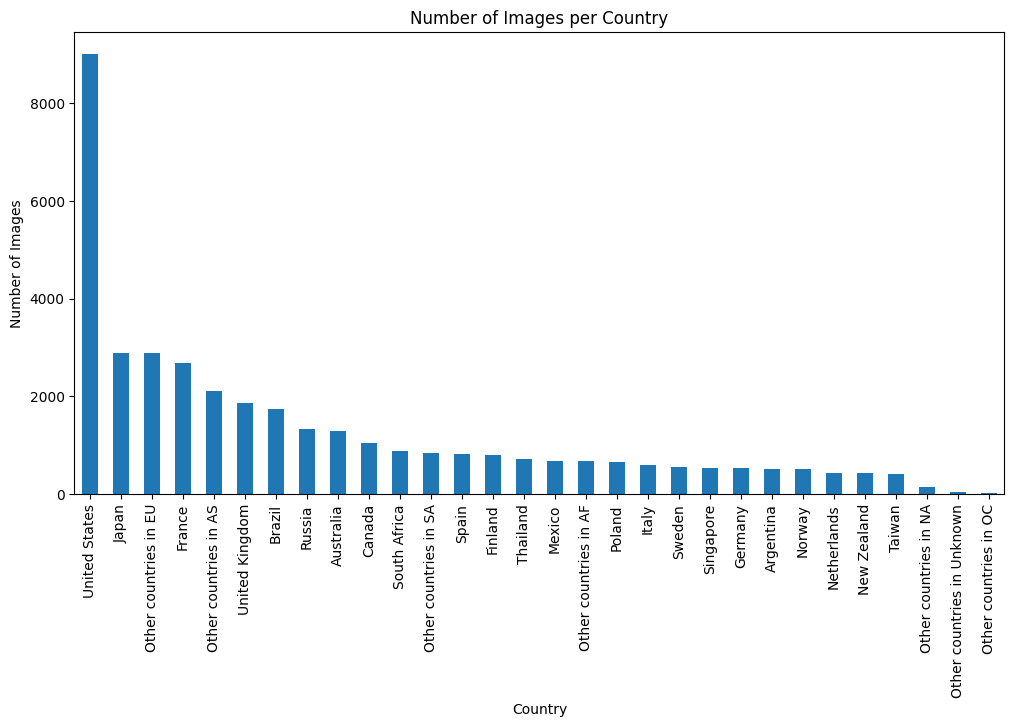

In [ ]:
## Let's visualize the distribution of images per country
# getting rid of augmented train from before
train_df = train_df[~train_df['img_path'].str.contains('augmented_train', na=False)]

country_counts = train_df['country'].value_counts()
plt.figure(figsize=(12, 6))
country_counts.plot(kind='bar')
plt.title('Number of Images per Country')
plt.xlabel('Country')
plt.ylabel('Number of Images')
plt.show()

## 2) Augmenting Training Set w/ Altered Images from Classes with Less Images
- Crop and adjust, making random permuatations
- Each class in training set will have >=1000 observations

In [ ]:
# base folder where the imgs actually are
base_image_dir = "/kaggle/input/geolocation-geoguessr-images-50k/compressed_dataset"  # might need to tweak

# where the CSV is (has img_path + country)
csv_path = "train_dataset.csv"

# folder to drop augmented imgs into
augmented_dir = "augmented_train"
os.makedirs(augmented_dir, exist_ok=True)

# set seeds so stuff isn’t random every run
random.seed(42)
np.random.seed(42)

# load dataset
train_df = pd.read_csv(csv_path)

# get rid of older augmented stuff so we dont duplicate
train_df = train_df[~train_df['img_path'].str.contains('augmented_train', na=False)]

# augmentation fn
def augment_image(image):
    # basic augmentation combo, works fine for now
    augmentations = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomResizedCrop(size=image.size[0], scale=(0.8, 1.0))
    ])
    return augmentations(image)

# doing oversampling for the smaller classes
target_count = 1000  # want every country to have at least this much
class_counts = train_df['country'].value_counts()
augmented_data = []

for country, count in class_counts.items():
    if count < target_count:
        needed = target_count - count
        country_images = train_df[train_df['country'] == country]['img_path'].tolist()
        print(f"Augmenting {country}: {count} → {target_count} (+{needed})")

        for i in range(needed):
            img_path = random.choice(country_images)

            # fixing weird prefix issue in the dataset (csv paths were wrong)
            fixed_path = img_path.replace("geoguessr_data/compressed_dataset", "").lstrip("/")

            full_img_path = os.path.join(base_image_dir, fixed_path)

            if not os.path.exists(full_img_path):
                print(f"Skipping missing image: {full_img_path}")
                continue

            try:
                img = Image.open(full_img_path).convert("RGB")
                aug_img = augment_image(img)
            except Exception as e:
                print(f"Error opening {full_img_path}: {e}")
                continue

            aug_filename = f"{country}_{i}_{os.path.basename(img_path)}"
            aug_img_path = os.path.join(augmented_dir, aug_filename)
            aug_img.save(aug_img_path)

            augmented_data.append((aug_img_path, country))

# combine and save all data
augmented_df = pd.DataFrame(augmented_data, columns=["img_path", "country"])
train_df = pd.concat([train_df, augmented_df], ignore_index=True)
print(f"\n Training dataset size after augmentation: {len(train_df)}")

train_df.to_csv("train_dataset.csv", index=False)
val_df.to_csv("val_dataset.csv", index=False)
test_df.to_csv("test_dataset.csv", index=False)

print("\n Saved splits:")
print(f"  train_dataset.csv → {len(train_df)} rows")
print(f"  val_dataset.csv   → {len(val_df)} rows")
print(f"  test_dataset.csv  → {len(test_df)} rows")
print(f"  Augmented images saved under: {augmented_dir}")


Augmenting South Africa: 887 → 1000 (+113)
Augmenting Other countries in SA: 837 → 1000 (+163)
Augmenting Spain: 806 → 1000 (+194)
Augmenting Finland: 787 → 1000 (+213)
Augmenting Thailand: 708 → 1000 (+292)
Augmenting Mexico: 676 → 1000 (+324)
Augmenting Other countries in AF: 668 → 1000 (+332)
Augmenting Poland: 647 → 1000 (+353)
Augmenting Italy: 592 → 1000 (+408)
Augmenting Sweden: 544 → 1000 (+456)
Augmenting Singapore: 530 → 1000 (+470)
Augmenting Germany: 524 → 1000 (+476)
Augmenting Argentina: 517 → 1000 (+483)
Augmenting Norway: 506 → 1000 (+494)
Augmenting Netherlands: 434 → 1000 (+566)
Augmenting New Zealand: 418 → 1000 (+582)
Augmenting Taiwan: 410 → 1000 (+590)
Augmenting Other countries in NA: 143 → 1000 (+857)
Augmenting Other countries in Unknown: 42 → 1000 (+958)
Augmenting Other countries in OC: 26 → 1000 (+974)

 Training dataset size after augmentation: 46795

 Saved splits:
  train_dataset.csv → 46795 rows
  val_dataset.csv   → 5000 rows
  test_dataset.csv  → 7500 

In [ ]:
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))


Device: cuda


## 3) Visualizing New Training Set
- After augmentation

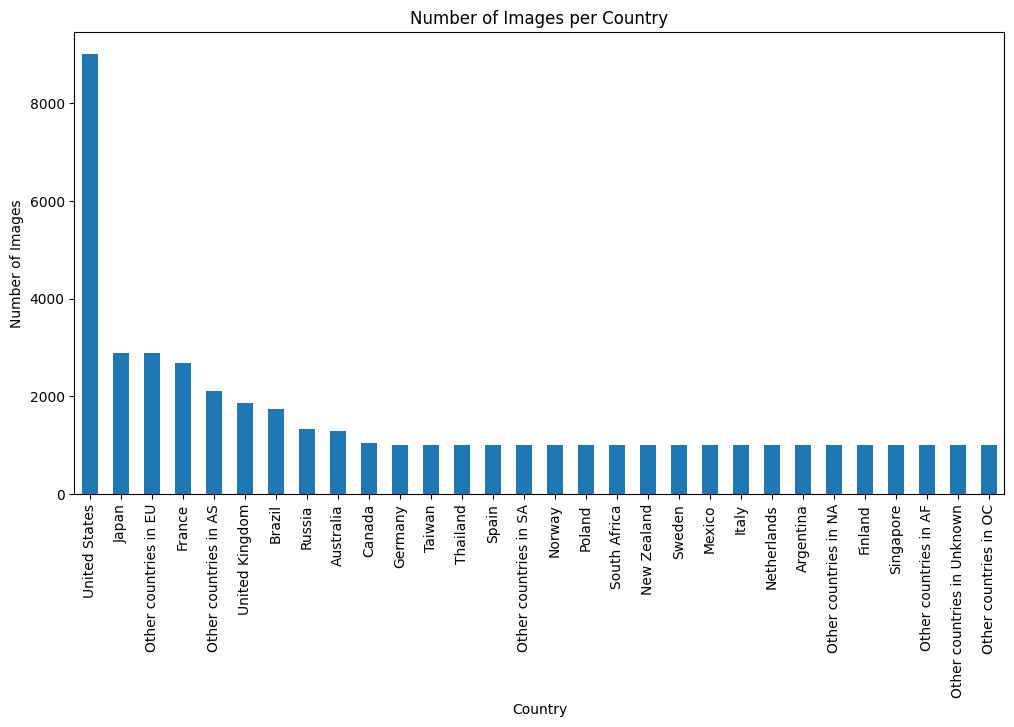

In [ ]:
## Let's visualize the distribution of images per country

country_counts = train_df['country'].value_counts()
plt.figure(figsize=(12, 6))
country_counts.plot(kind='bar')
plt.title('Number of Images per Country')
plt.xlabel('Country')
plt.ylabel('Number of Images')
plt.show()

## 4) Looking at a random subset of images to see how our data appears


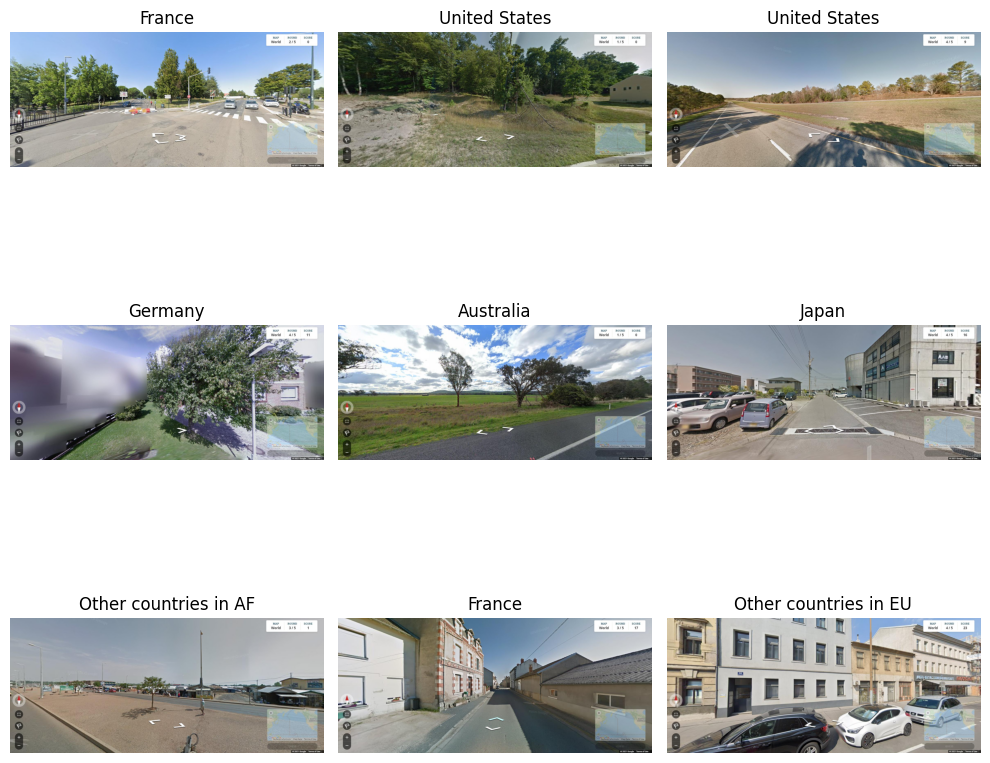

Augmented Image Sample
--------------------------------------
--------------------------------------


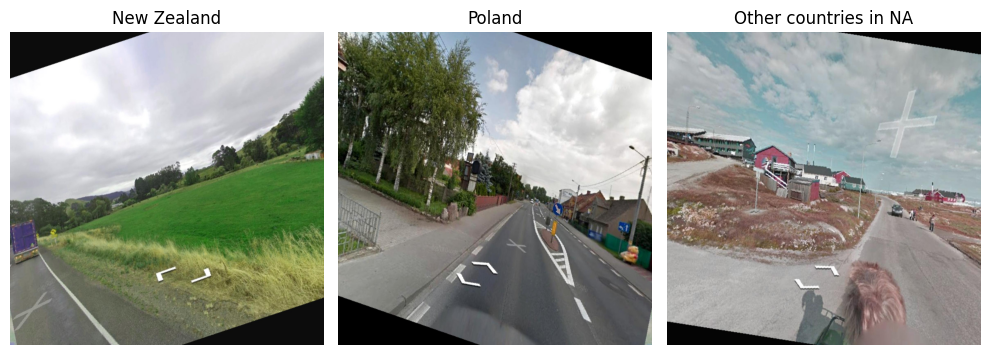

In [ ]:
# Let's see some images and their labels
# We will show 9 random images

np.random.seed(2025)

sampled_df = train_df.sample(9).reset_index(drop=True)
for split_name, split_df in [('train', train_df), ('val', val_df), ('test', test_df)]:
    # Fix image paths
    split_df['full_img_path'] = split_df['img_path'].apply(
        lambda x: os.path.join(base_image_dir, x.replace('geoguessr_data/compressed_dataset/', ''))
    )

# Test by displaying sample images
train_not_augmented = train_df[~train_df['img_path'].str.contains('augmented_train')]
sampled_df = train_not_augmented.sample(9).reset_index(drop=True)

plt.figure(figsize=(10, 10))
for i in range(9):
    img_path = sampled_df.loc[i, 'full_img_path']
    try:
        img = Image.open(img_path)
        label = sampled_df.loc[i, 'country']
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    except FileNotFoundError:
        print(f"Missing file: {img_path}")
plt.tight_layout()
plt.show()


np.random.seed(2025)
from PIL import Image
for split_name, split_df in [('train', train_df), ('val', val_df), ('test', test_df)]:
    # Fix image paths
    split_df['full_img_path'] = split_df['img_path'].apply(
        lambda x: os.path.join(base_image_dir, x.replace('geoguessr_data/compressed_dataset/', ''))
    )

augmented_df['full_img_path'] = augmented_df['img_path'].apply(
    lambda x: x.replace('geoguessr_data/compressed_dataset/', ''))


# est by displaying sample images
sampled_df = augmented_df.sample(3).reset_index(drop=True)
print("Augmented Image Sample")
print("--------------------------------------")
print("--------------------------------------")
plt.figure(figsize=(10, 10))
for i in range(3):
    img_path = sampled_df.loc[i, 'full_img_path']
    try:
        img = Image.open(img_path)
        label = sampled_df.loc[i, 'country']
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    except FileNotFoundError:
        print(f"Missing file: {img_path}")
plt.tight_layout()
plt.show()




## Base CNN Validation

In [ ]:
# basic settings for the run
CSV_PATH = "geoguessr_images_dataset.csv"  # csv file location
IMAGE_ROOT = path  # folder that has all the imgs
BATCH_SIZE = 100
NUM_EPOCHS = 10
LR = 1e-3
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHECKPOINT_DIR = "checkpoints"  # where I'm saving models

# dataset class
class GeoDataset(Dataset):
    def __init__(self, df, img_root, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_root = img_root
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # csv paths had this prefix, removing it
        file_name = row['img_path'].replace('geoguessr_data/', '')
        img_path = self.img_root + '/' + file_name
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = row['label']
        return image, label

# computes top-k acc
def topk_accuracy(outputs, labels, k=3):
    _, topk_preds = outputs.topk(k, dim=1)
    correct_topk = topk_preds.eq(labels.view(-1, 1).expand_as(topk_preds))
    return correct_topk.sum().item()

# transformations on imgs
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# get rid of any row w/ augmented imgs so we dont train twice on them
train_df = train_df[~train_df['img_path'].str.contains('augmented_train')]
val_df = val_df[~val_df['img_path'].str.contains('augmented_train')]
test_df = test_df[~test_df['img_path'].str.contains('augmented_train')]

# some old rows had weird prefixes, so just re-encode labels cleanly
le = LabelEncoder()
whole_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

train_df['label'] = le.fit_transform(train_df['country'])
val_df['label'] = le.transform(val_df['country'])
test_df['label'] = le.transform(test_df['country'])

# hook the df's into pytorch datasets
train_dataset = GeoDataset(train_df, IMAGE_ROOT, transform=transform)
val_dataset = GeoDataset(val_df, IMAGE_ROOT, transform=transform)
test_dataset = GeoDataset(test_df, IMAGE_ROOT, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# check what device we're actually using
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
# try first finding good hyperparams for the CNN
# just using a small chunk of data so it doesnt take forever


BATCH_SIZE = 100
train_df_subset = train_df.sample(n=5000, random_state=42).reset_index(drop=True)
val_df_subset = val_df.sample(n=1000, random_state=42).reset_index(drop=True)

train_dataset_subset = GeoDataset(train_df_subset, IMAGE_ROOT, transform=transform)
val_dataset_subset = GeoDataset(val_df_subset, IMAGE_ROOT, transform=transform)

train_loader_subset = DataLoader(train_dataset_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader_subset = DataLoader(val_dataset_subset, batch_size=BATCH_SIZE, shuffle=False)



le = LabelEncoder()
# fitting labels on train+val so its consistent
whole_df = pd.concat([train_df, val_df], ignore_index=True)
le.fit(whole_df["country"])
train_df["country"] = le.transform(train_df["country"])
val_df["country"] = le.transform(val_df["country"])


class SimpleCNN(nn.Module):
    def __init__(self, num_classes=30, num_filters=32, kernel_size=3):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, num_filters, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel_size, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # calculate flattened size (honestly easier than doing hand math lol)
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 224, 224)
            dummy_out = self._forward_conv(dummy)
            self.flatten_dim = dummy_out.numel()

        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def _forward_conv(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# train + val functions
def train_one_epoch(model, loader, optimizer, criterion, device, epoch, config_name, log_list):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    start_time = time.time()
    num_batches = len(loader)
    print(f"Training Epoch {epoch} | {config_name} | {num_batches} batches")

    for i, (images, labels) in enumerate(loader, start=1):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # show some progress so we know it's not stuck
        if i % max(1, num_batches // 10) == 0:
            elapsed = time.time() - start_time
            progress = (i / num_batches) * 100
            est_total_time = (elapsed / (i / num_batches))
            remaining = est_total_time - elapsed
            print(f"   {progress:.1f}% done | Avg loss: {running_loss / total:.4f}, "
                  f"Acc: {correct / total:.4f} | ETA: {remaining / 60:.1f} min")

    avg_loss, avg_acc = running_loss / total, correct / total
    log_list.append({
        'phase': 'train',
        'epoch': epoch,
        'config': config_name,
        'loss': avg_loss,
        'acc': avg_acc
    })
    return avg_loss, avg_acc


def evaluate(model, loader, criterion, device, epoch, config_name, log_list):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    start_time = time.time()
    num_batches = len(loader)
    print(f"Validating Epoch {epoch} | {config_name} | {num_batches} batches")

    with torch.no_grad():
        for i, (images, labels) in enumerate(loader, start=1):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # again showing progress (validation can feel slow)
            if i % max(1, num_batches // 10) == 0:
                elapsed = time.time() - start_time
                progress = (i / num_batches) * 100
                est_total_time = (elapsed / (i / num_batches))
                remaining = est_total_time - elapsed
                print(f"   {progress:.1f}% done | Avg loss: {running_loss / total:.4f}, "
                      f"Acc: {correct / total:.4f} | ETA: {remaining / 60:.1f} min")

    avg_loss, avg_acc = running_loss / total, correct / total
    log_list.append({
        'phase': 'val',
        'epoch': epoch,
        'config': config_name,
        'loss': avg_loss,
        'acc': avg_acc
    })
    return avg_loss, avg_acc

# hyperparam search loop
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
num_classes = len(le.classes_)  # num of countries basically

cnn_hyperparams = [
    {'num_filters': 32, 'kernel_size': 3, 'lr': 1e-3},
    {'num_filters': 64, 'kernel_size': 3, 'lr': 1e-3},
    {'num_filters': 32, 'kernel_size': 5, 'lr': 1e-3},
    {'num_filters': 64, 'kernel_size': 5, 'lr': 1e-3},
]

best_model = None
best_val_acc = 0.0
results = []
log_list = []

for hparams in cnn_hyperparams:
    config_name = f"filters{hparams['num_filters']}_k{hparams['kernel_size']}_lr{hparams['lr']}"
    print(f"\nTesting config: {config_name}")

    model = SimpleCNN(
        num_classes=num_classes,
        num_filters=hparams['num_filters'],
        kernel_size=hparams['kernel_size']
    ).to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=hparams['lr'])

    for epoch in range(1, 4):
        train_loss, train_acc = train_one_epoch(model, train_loader_subset, optimizer, criterion, DEVICE, epoch, config_name, log_list)
        val_loss, val_acc = evaluate(model, val_loader_subset, criterion, DEVICE, epoch, config_name, log_list)
        print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Acc {val_acc:.4f}")

    results.append({
        'config': config_name,
        'num_filters': hparams['num_filters'],
        'kernel_size': hparams['kernel_size'],
        'lr': hparams['lr'],
        'val_acc': val_acc,
        'val_loss': val_loss
    })

    # update best found
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model.state_dict()
        best_config = hparams.copy()

# save best model + logs
os.makedirs("checkpoints", exist_ok=True)

torch.save({
    "model_state_dict": best_model,
    "best_config": best_config,
    "results": results
}, "checkpoints/best_cnn_model.pt")

log_df = pd.DataFrame(log_list)
log_df.to_csv("cnn_training_log.csv", index=False)

print("\nBest CNN config:", best_config)
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print("All results:")
print(pd.DataFrame(results))
print("\nFull log saved to cnn_training_log.csv")


Tried some hyperparameter combos. Went with 32 filters and kernel size 5 (see above architecture for all details)

In [ ]:
# Settings
BATCH_SIZE = 100
train_df_subset = train_df.sample(n=5000, random_state=42).reset_index(drop=True)
val_df_subset = val_df.sample(n=1000, random_state=42).reset_index(drop=True)

train_dataset_subset = GeoDataset(train_df_subset, IMAGE_ROOT, transform=transform)
val_dataset_subset = GeoDataset(val_df_subset, IMAGE_ROOT, transform=transform)

train_loader_subset = DataLoader(train_dataset_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader_subset = DataLoader(val_dataset_subset, batch_size=BATCH_SIZE, shuffle=False)



le = LabelEncoder()
whole_df = pd.concat([train_df, val_df], ignore_index=True)
le.fit(whole_df["country"])
train_df["country"] = le.transform(train_df["country"])
val_df["country"] = le.transform(val_df["country"])


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 224
NUM_EPOCHS = 10
BATCH_SIZE = 64
LR = 1e-3
CHECKPOINT_DIR = "checkpoints"
RESUME_CKPT = "checkpoints/best_cnn_model.pt"

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=30, num_filters=32, kernel_size=3, img_size=IMG_SIZE):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, num_filters, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(num_filters*2, num_filters*4, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(num_filters*4),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 3, img_size, img_size)
            dummy_out = self.features(dummy)
            self.flatten_dim = dummy_out.numel()

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


def save_checkpoint(model, optimizer, epoch, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)
    print(f"Saved checkpoint: {path}")


def load_checkpoint(model, optimizer, path, device=DEVICE):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Resumed from checkpoint '{path}' at epoch {checkpoint['epoch']}")
        return checkpoint['epoch']
    return 0


train_acc = []
val_acc = []

def train_model(model, train_loader, val_loader, num_epochs=NUM_EPOCHS, lr=LR,
                save_interval=1, save_dir=CHECKPOINT_DIR, resume_path=None):
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    start_epoch = 0

    if resume_path is not None:
        start_epoch = load_checkpoint(model, optimizer, resume_path, DEVICE)

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss, correct_top1, correct_top3, total = 0, 0, 0, 0

        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE, dtype=torch.long)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct_top1 += (preds == labels).sum().item()
            correct_top3 += topk_accuracy(outputs, labels, k=3)
            total += labels.size(0)

        print(f"Train Loss: {running_loss/total:.4f}, "
              f"Top-1 Acc: {correct_top1/total:.4f}, "
              f"Top-3 Acc: {correct_top3/total:.4f}")
        train_acc.append(correct_top1/total)

        model.eval()
        correct_top1, correct_top3, total = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE, dtype=torch.long)
                outputs = model(imgs)
                _, preds = outputs.max(1)
                correct_top1 += (preds == labels).sum().item()
                correct_top3 += topk_accuracy(outputs, labels, k=3)
                total += labels.size(0)

        print(f"Val Top-1 Acc: {correct_top1/total:.4f}, "
              f"Top-3 Acc: {correct_top3/total:.4f}")
        val_acc.append(correct_top1/total)

        if (epoch + 1) % save_interval == 0:
            ckpt_path = os.path.join(save_dir, f"{model.__class__.__name__}_epoch{epoch+1}.pt")
            save_checkpoint(model, optimizer, epoch+1, ckpt_path)

        if len(val_acc) > 1 and val_acc[-1] < val_acc[-2]:
            print("Val acc decreased twice in a row. Stopping training. Possible Overfitting")
            break


num_classes = len(le.classes_)
cnn_model = SimpleCNN(num_classes=num_classes, num_filters=32, kernel_size=5, img_size=IMG_SIZE)
train_model(cnn_model, train_loader, val_loader, resume_path=None)

df = pd.DataFrame({'train_acc': train_acc, 'val_acc': val_acc})
df.to_csv('cnn_acc.csv', index=False)



Epoch 1/10: 100%|██████████| 375/375 [08:05<00:00,  1.29s/it]


Train Loss: 3.8243, Top-1 Acc: 0.0717, Top-3 Acc: 0.3085
Val Top-1 Acc: 0.0766, Top-3 Acc: 0.3884
Saved checkpoint: checkpoints/SimpleCNN_epoch1.pt


Epoch 2/10: 100%|██████████| 375/375 [08:05<00:00,  1.30s/it]


Train Loss: 3.0882, Top-1 Acc: 0.2327, Top-3 Acc: 0.3891
Val Top-1 Acc: 0.2404, Top-3 Acc: 0.3884
Saved checkpoint: checkpoints/SimpleCNN_epoch2.pt


Epoch 3/10: 100%|██████████| 375/375 [08:13<00:00,  1.32s/it]


Train Loss: 2.9724, Top-1 Acc: 0.2403, Top-3 Acc: 0.3886
Val Top-1 Acc: 0.2404, Top-3 Acc: 0.3892
Saved checkpoint: checkpoints/SimpleCNN_epoch3.pt


Epoch 4/10: 100%|██████████| 375/375 [08:14<00:00,  1.32s/it]


Train Loss: 2.9299, Top-1 Acc: 0.2403, Top-3 Acc: 0.3900
Val Top-1 Acc: 0.2404, Top-3 Acc: 0.3866
Saved checkpoint: checkpoints/SimpleCNN_epoch4.pt


Epoch 5/10: 100%|██████████| 375/375 [08:10<00:00,  1.31s/it]


Train Loss: 2.8947, Top-1 Acc: 0.2403, Top-3 Acc: 0.3937
Val Top-1 Acc: 0.2404, Top-3 Acc: 0.3998
Saved checkpoint: checkpoints/SimpleCNN_epoch5.pt


Epoch 6/10: 100%|██████████| 375/375 [08:08<00:00,  1.30s/it]


Train Loss: 2.8757, Top-1 Acc: 0.2403, Top-3 Acc: 0.3936
Val Top-1 Acc: 0.2404, Top-3 Acc: 0.4022
Saved checkpoint: checkpoints/SimpleCNN_epoch6.pt


Epoch 7/10: 100%|██████████| 375/375 [08:09<00:00,  1.30s/it]


Train Loss: 2.8657, Top-1 Acc: 0.2403, Top-3 Acc: 0.3961
Val Top-1 Acc: 0.2404, Top-3 Acc: 0.4034
Saved checkpoint: checkpoints/SimpleCNN_epoch7.pt


Epoch 8/10: 100%|██████████| 375/375 [08:14<00:00,  1.32s/it]


Train Loss: 2.8555, Top-1 Acc: 0.2403, Top-3 Acc: 0.3955
Val Top-1 Acc: 0.2404, Top-3 Acc: 0.3956
Saved checkpoint: checkpoints/SimpleCNN_epoch8.pt


Epoch 9/10:  17%|█▋        | 65/375 [01:25<06:47,  1.32s/it]


KeyboardInterrupt: 

^^ Stopped training because val acc stopped improving... wanted to see why

In [ ]:
df = pd.DataFrame({'train_acc': train_acc, 'val_acc': val_acc})
df.to_csv('cnn_acc.csv', index=False)

Text(0, 0.5, 'Accuracy')

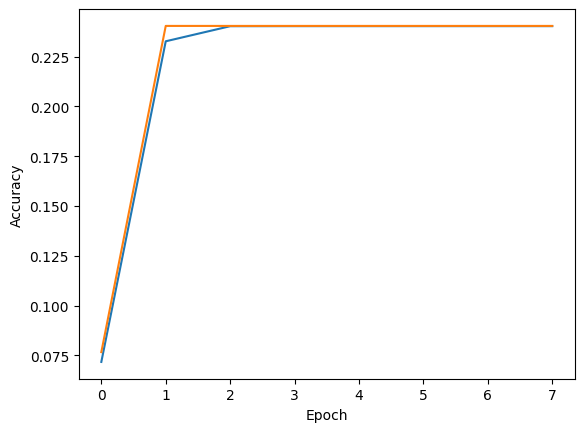

In [ ]:
# Plot train vs val accuracy

df = pd.read_csv('cnn_acc.csv')
plt.plot(df['train_acc'], label='Train')
plt.plot(df['val_acc'], label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

The reason is that the model isn't good enough at differentiating ANYTHING... so it only predicts U.S. because it's the most prominent class. Not great. (Might look into ways that we could improve (maybe change loss function?) this but even after improving class imbalance, the model performs poorly)

Test Top-1 Acc: 0.2403, Top-3 Acc: 0.3976


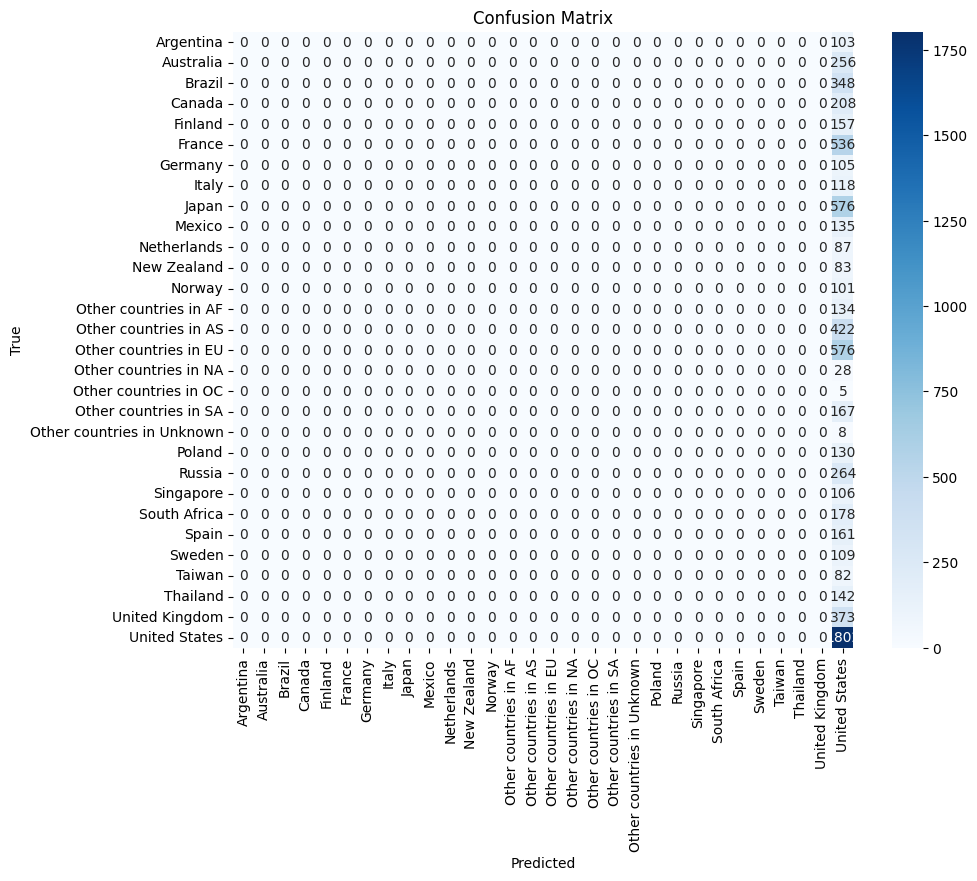

In [ ]:
#plot confusion matrix on test set


# get test set predictions
test_preds = []
test_labels = []
correct_top1, correct_top3, total = 0, 0, 0
cnn_model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE, dtype=torch.long)
        outputs = cnn_model(imgs)
        _, preds = outputs.max(1)
        correct_top1 += (preds == labels).sum().item()
        correct_top3 += topk_accuracy(outputs, labels, k=3)
        total += labels.size(0)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

print(f"Test Top-1 Acc: {correct_top1/total:.4f}, "
      f"Top-3 Acc: {correct_top3/total:.4f}")

# confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# F1 calculations

from sklearn.metrics import f1_score

test_preds = []
test_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE, dtype=torch.long)
        #outputs = cnn_model(imgs)
        #_, preds = outputs.max(1)
        #correct_top1 += (preds == labels).sum().item()
        #correct_top3 += topk_accuracy(outputs, labels, k=3)
        #total += labels.size(0)
        #test_preds.extend(preds.cpu().numpy())
        # test preds is only US, so let's just hardcode this so don't need to keep running/retraining
        preds = [29] * len(labels)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(preds)


f1_micro = f1_score(test_labels, test_preds, average='micro')
f1_macro = f1_score(test_labels, test_preds, average='macro')


In [ ]:
f1_micro

0.24026666666666666

In [ ]:
f1_macro

0.012914785350820612

In [ ]:
import torch

# define model again (must match checkpoint config)
cnn_model = SimpleCNN(num_classes)
cnn_model = cnn_model.to(DEVICE)

# --- Load checkpoint ---
RESUME_CKPT = "checkpoints/best_cnn_model.pt"  # or your most recent path
checkpoint = torch.load(RESUME_CKPT, map_location=DEVICE)

# Load model weights
cnn_model.load_state_dict(checkpoint["model_state_dict"])

# If you want to continue training, restore optimizer and epoch
if "optimizer_state_dict" in checkpoint:
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=checkpoint.get("best_config", {}).get("lr", 1e-3))
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint.get("epoch", 0) + 1
    print(f"Resumed training from epoch {start_epoch}")
else:
    optimizer = None
    start_epoch = 0
    print("No optimizer state found — starting fresh evaluation mode.")

# Evaluate the loaded model
def topk_accuracy(output, target, k=5):
    """Computes top-k accuracy."""
    with torch.no_grad():
        _, pred = output.topk(k, 1, True, True)
        correct = pred.eq(target.view(-1, 1).expand_as(pred))
        return correct.sum().item()

def evaluate_model(model, test_loader):
    model.eval()
    correct_top1 = 0
    correct_top3 = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)

            # top-1
            _, preds = torch.max(outputs, 1)
            correct_top1 += (preds == labels).sum().item()

            # top-5
            correct_top3 += topk_accuracy(outputs, labels, k=3)
            total += labels.size(0)

    print(f"\nEvaluated Checkpoint: {RESUME_CKPT}")
    print(f"Top-1 Accuracy: {correct_top1 / total:.4f}")
    print(f"Top-3 Accuracy: {correct_top3 / total:.4f}")

# Run evaluation
evaluate_model(cnn_model, test_loader)

^^ This was to help with resuming from a checkpoint

## ResNet50 Validation

Taking ResNet50 structure and recalculating weights

In [ ]:
from torchvision import models, transforms

# Detect best available device (GPU > MPS > CPU)
DEVICE = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

num_classes = len(train_df["country"].unique())
LOG_PATH = "cnn_training_log.csv"

BATCH_SIZE = 300

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

class ResNet50Baseline(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Standard ResNet backbone
        self.model = models.resnet50(pretrained=pretrained)
        in_features = self.model.fc.in_features
        # Replace classifier head for our labels
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Using non-pretrained to keep experiment clean
model = ResNet50Baseline(num_classes=num_classes, pretrained=False).to(DEVICE)

# Just a quick sanity check on what's trainable
trainable_params = [n for n, p in model.named_parameters() if p.requires_grad]
print(f"Trainable parameters: {trainable_params}")
print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3
)

def train_one_epoch(model, loader, optimizer, criterion, device, epoch, total_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for batch_idx, (images, labels) in enumerate(
        tqdm(loader, leave=False, desc=f"Train Epoch {epoch+1}/{total_epochs}")
    ):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Light logging every few batches so output isn't insane
        if (batch_idx + 1) % 10 == 0:
            print(f"[Train] Epoch {epoch+1}/{total_epochs} | "
                  f"Batch {batch_idx+1}/{len(loader)} | Loss: {loss.item():.4f}")

    return running_loss / total, correct / total


def evaluate(model, loader, criterion, device, epoch, total_epochs):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(
            tqdm(loader, leave=False, desc=f"Val Epoch {epoch+1}/{total_epochs}")
        ):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total


# Running only 4 epochs for quick debugging
EPOCHS = 20
log_records = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE, epoch, EPOCHS)
    val_loss, val_acc = evaluate(model, val_loader, criterion, DEVICE, epoch, EPOCHS)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    log_records.append({
        'phase': 'train', 'epoch': epoch+1, 'config': 'ResNet50_lr1e-4',
        'loss': train_loss, 'acc': train_acc
    })
    log_records.append({
        'phase': 'val', 'epoch': epoch+1, 'config': 'ResNet50_lr1e-4',
        'loss': val_loss, 'acc': val_acc
    })

    # Simple, human-readable early stopping check
    if len(log_records) > 1 and log_records[-1]['phase'] == 'val':
        if log_records[-1]['acc'] <= log_records[-2]['acc']:
            print("Val accuracy dropped. Might be early overfitting; stopping.")
            break

# Append logs to CSV if it exists
try:
    df_log = pd.read_csv(LOG_PATH)
    df_log = pd.concat([df_log, pd.DataFrame(log_records)], ignore_index=True)
except FileNotFoundError:
    df_log = pd.DataFrame(log_records)


🔍 Trainable parameters: ['model.conv1.weight', 'model.bn1.weight', 'model.bn1.bias', 'model.layer1.0.conv1.weight', 'model.layer1.0.bn1.weight', 'model.layer1.0.bn1.bias', 'model.layer1.0.conv2.weight', 'model.layer1.0.bn2.weight', 'model.layer1.0.bn2.bias', 'model.layer1.0.conv3.weight', 'model.layer1.0.bn3.weight', 'model.layer1.0.bn3.bias', 'model.layer1.0.downsample.0.weight', 'model.layer1.0.downsample.1.weight', 'model.layer1.0.downsample.1.bias', 'model.layer1.1.conv1.weight', 'model.layer1.1.bn1.weight', 'model.layer1.1.bn1.bias', 'model.layer1.1.conv2.weight', 'model.layer1.1.bn2.weight', 'model.layer1.1.bn2.bias', 'model.layer1.1.conv3.weight', 'model.layer1.1.bn3.weight', 'model.layer1.1.bn3.bias', 'model.layer1.2.conv1.weight', 'model.layer1.2.bn1.weight', 'model.layer1.2.bn1.bias', 'model.layer1.2.conv2.weight', 'model.layer1.2.bn2.weight', 'model.layer1.2.bn2.bias', 'model.layer1.2.conv3.weight', 'model.layer1.2.bn3.weight', 'model.layer1.2.bn3.bias', 'model.layer2.0.conv

Train Epoch 1/20:   8%|▊         | 10/125 [00:12<02:03,  1.07s/it]

🟩 [Train] Epoch 1/20 | Batch 10/125 | Loss: 3.0290


Train Epoch 1/20:  16%|█▌        | 20/125 [00:21<01:14,  1.42it/s]

🟩 [Train] Epoch 1/20 | Batch 20/125 | Loss: 2.8946


Train Epoch 1/20:  24%|██▍       | 30/125 [00:31<01:36,  1.02s/it]

🟩 [Train] Epoch 1/20 | Batch 30/125 | Loss: 2.6910


Train Epoch 1/20:  32%|███▏      | 40/125 [00:40<00:59,  1.42it/s]

🟩 [Train] Epoch 1/20 | Batch 40/125 | Loss: 2.7427


Train Epoch 1/20:  40%|████      | 50/125 [00:51<01:16,  1.02s/it]

🟩 [Train] Epoch 1/20 | Batch 50/125 | Loss: 2.7426


Train Epoch 1/20:  48%|████▊     | 60/125 [00:59<00:45,  1.41it/s]

🟩 [Train] Epoch 1/20 | Batch 60/125 | Loss: 2.6981


Train Epoch 1/20:  56%|█████▌    | 70/125 [01:10<00:55,  1.02s/it]

🟩 [Train] Epoch 1/20 | Batch 70/125 | Loss: 2.5910


Train Epoch 1/20:  64%|██████▍   | 80/125 [01:18<00:32,  1.40it/s]

🟩 [Train] Epoch 1/20 | Batch 80/125 | Loss: 2.7163


Train Epoch 1/20:  72%|███████▏  | 90/125 [01:29<00:33,  1.03it/s]

🟩 [Train] Epoch 1/20 | Batch 90/125 | Loss: 2.6903


Train Epoch 1/20:  80%|████████  | 100/125 [01:38<00:22,  1.13it/s]

🟩 [Train] Epoch 1/20 | Batch 100/125 | Loss: 2.5281


Train Epoch 1/20:  88%|████████▊ | 110/125 [01:48<00:13,  1.08it/s]

🟩 [Train] Epoch 1/20 | Batch 110/125 | Loss: 2.5875


Train Epoch 1/20:  96%|█████████▌| 120/125 [01:57<00:05,  1.06s/it]

🟩 [Train] Epoch 1/20 | Batch 120/125 | Loss: 2.6297


✅ Epoch 1/20 | Train Loss: 2.7399, Acc: 0.2520 | Val Loss: 2.6634, Acc: 0.2560


Train Epoch 2/20:   8%|▊         | 10/125 [00:12<01:57,  1.03s/it]

🟩 [Train] Epoch 2/20 | Batch 10/125 | Loss: 2.5806


Train Epoch 2/20:  16%|█▌        | 20/125 [00:20<01:12,  1.45it/s]

🟩 [Train] Epoch 2/20 | Batch 20/125 | Loss: 2.4453


Train Epoch 2/20:  24%|██▍       | 30/125 [00:30<01:31,  1.03it/s]

🟩 [Train] Epoch 2/20 | Batch 30/125 | Loss: 2.4761


Train Epoch 2/20:  32%|███▏      | 40/125 [00:38<00:57,  1.47it/s]

🟩 [Train] Epoch 2/20 | Batch 40/125 | Loss: 2.3951


Train Epoch 2/20:  40%|████      | 50/125 [00:48<01:12,  1.04it/s]

🟩 [Train] Epoch 2/20 | Batch 50/125 | Loss: 2.5103


Train Epoch 2/20:  48%|████▊     | 60/125 [00:57<00:44,  1.47it/s]

🟩 [Train] Epoch 2/20 | Batch 60/125 | Loss: 2.3183


Train Epoch 2/20:  56%|█████▌    | 70/125 [01:07<00:53,  1.03it/s]

🟩 [Train] Epoch 2/20 | Batch 70/125 | Loss: 2.4892


Train Epoch 2/20:  64%|██████▍   | 80/125 [01:15<00:30,  1.47it/s]

🟩 [Train] Epoch 2/20 | Batch 80/125 | Loss: 2.3974


Train Epoch 2/20:  72%|███████▏  | 90/125 [01:25<00:34,  1.02it/s]

🟩 [Train] Epoch 2/20 | Batch 90/125 | Loss: 2.3589


Train Epoch 2/20:  80%|████████  | 100/125 [01:34<00:17,  1.45it/s]

🟩 [Train] Epoch 2/20 | Batch 100/125 | Loss: 2.3800


Train Epoch 2/20:  88%|████████▊ | 110/125 [01:44<00:14,  1.01it/s]

🟩 [Train] Epoch 2/20 | Batch 110/125 | Loss: 2.2957


Train Epoch 2/20:  96%|█████████▌| 120/125 [01:52<00:03,  1.46it/s]

🟩 [Train] Epoch 2/20 | Batch 120/125 | Loss: 2.3681


✅ Epoch 2/20 | Train Loss: 2.4216, Acc: 0.3070 | Val Loss: 2.7577, Acc: 0.2432
Val acc decreased twice in a row. Stopping training. Possible Overfitting


Train Epoch 3/20:   8%|▊         | 10/125 [00:12<01:58,  1.03s/it]

🟩 [Train] Epoch 3/20 | Batch 10/125 | Loss: 2.3173


Train Epoch 3/20:  16%|█▌        | 20/125 [00:20<01:13,  1.44it/s]

🟩 [Train] Epoch 3/20 | Batch 20/125 | Loss: 2.2397


Train Epoch 3/20:  24%|██▍       | 30/125 [00:31<01:35,  1.00s/it]

🟩 [Train] Epoch 3/20 | Batch 30/125 | Loss: 2.2632


Train Epoch 3/20:  32%|███▏      | 40/125 [00:39<00:58,  1.44it/s]

🟩 [Train] Epoch 3/20 | Batch 40/125 | Loss: 2.2440


Train Epoch 3/20:  40%|████      | 50/125 [00:50<01:14,  1.01it/s]

🟩 [Train] Epoch 3/20 | Batch 50/125 | Loss: 2.3019


Train Epoch 3/20:  48%|████▊     | 60/125 [00:58<00:44,  1.46it/s]

🟩 [Train] Epoch 3/20 | Batch 60/125 | Loss: 2.2351


Train Epoch 3/20:  56%|█████▌    | 70/125 [01:08<00:54,  1.01it/s]

🟩 [Train] Epoch 3/20 | Batch 70/125 | Loss: 2.1653


Train Epoch 3/20:  64%|██████▍   | 80/125 [01:17<00:33,  1.34it/s]

🟩 [Train] Epoch 3/20 | Batch 80/125 | Loss: 2.2904


Train Epoch 3/20:  72%|███████▏  | 90/125 [01:27<00:38,  1.11s/it]

🟩 [Train] Epoch 3/20 | Batch 90/125 | Loss: 2.1788


Train Epoch 3/20:  80%|████████  | 100/125 [01:36<00:18,  1.32it/s]

🟩 [Train] Epoch 3/20 | Batch 100/125 | Loss: 2.1897


Train Epoch 3/20:  88%|████████▊ | 110/125 [01:46<00:17,  1.15s/it]

🟩 [Train] Epoch 3/20 | Batch 110/125 | Loss: 2.2136


Train Epoch 3/20:  96%|█████████▌| 120/125 [01:54<00:03,  1.29it/s]

🟩 [Train] Epoch 3/20 | Batch 120/125 | Loss: 2.1843


✅ Epoch 3/20 | Train Loss: 2.2256, Acc: 0.3524 | Val Loss: 2.5033, Acc: 0.2776
Val acc decreased twice in a row. Stopping training. Possible Overfitting


Train Epoch 4/20:   8%|▊         | 10/125 [00:12<02:00,  1.05s/it]

🟩 [Train] Epoch 4/20 | Batch 10/125 | Loss: 2.1643


Train Epoch 4/20:  16%|█▌        | 20/125 [00:20<01:12,  1.44it/s]

🟩 [Train] Epoch 4/20 | Batch 20/125 | Loss: 2.1031


Train Epoch 4/20:  24%|██▍       | 30/125 [00:30<01:32,  1.03it/s]

🟩 [Train] Epoch 4/20 | Batch 30/125 | Loss: 2.2031


Train Epoch 4/20:  32%|███▏      | 40/125 [00:39<00:57,  1.47it/s]

🟩 [Train] Epoch 4/20 | Batch 40/125 | Loss: 2.0523


Train Epoch 4/20:  40%|████      | 50/125 [00:49<01:11,  1.05it/s]

🟩 [Train] Epoch 4/20 | Batch 50/125 | Loss: 2.0948


Train Epoch 4/20:  48%|████▊     | 60/125 [00:57<00:44,  1.44it/s]

🟩 [Train] Epoch 4/20 | Batch 60/125 | Loss: 2.1871


Train Epoch 4/20:  56%|█████▌    | 70/125 [01:07<00:54,  1.01it/s]

🟩 [Train] Epoch 4/20 | Batch 70/125 | Loss: 2.2929


Train Epoch 4/20:  64%|██████▍   | 80/125 [01:16<00:30,  1.47it/s]

🟩 [Train] Epoch 4/20 | Batch 80/125 | Loss: 1.9629


Train Epoch 4/20:  72%|███████▏  | 90/125 [01:26<00:34,  1.01it/s]

🟩 [Train] Epoch 4/20 | Batch 90/125 | Loss: 2.2820


Train Epoch 4/20:  80%|████████  | 100/125 [01:34<00:18,  1.35it/s]

🟩 [Train] Epoch 4/20 | Batch 100/125 | Loss: 2.1416


Train Epoch 4/20:  88%|████████▊ | 110/125 [01:44<00:13,  1.07it/s]

🟩 [Train] Epoch 4/20 | Batch 110/125 | Loss: 1.9661


Train Epoch 4/20:  96%|█████████▌| 120/125 [01:53<00:04,  1.20it/s]

🟩 [Train] Epoch 4/20 | Batch 120/125 | Loss: 2.0476


✅ Epoch 4/20 | Train Loss: 2.0774, Acc: 0.3893 | Val Loss: 2.2574, Acc: 0.3478
Val acc decreased twice in a row. Stopping training. Possible Overfitting


Train Epoch 5/20:   8%|▊         | 10/125 [00:12<02:00,  1.05s/it]

🟩 [Train] Epoch 5/20 | Batch 10/125 | Loss: 1.9764


Train Epoch 5/20:  16%|█▌        | 20/125 [00:21<01:15,  1.39it/s]

🟩 [Train] Epoch 5/20 | Batch 20/125 | Loss: 2.0519


Train Epoch 5/20:  24%|██▍       | 30/125 [00:31<01:38,  1.04s/it]

🟩 [Train] Epoch 5/20 | Batch 30/125 | Loss: 1.9131


Train Epoch 5/20:  32%|███▏      | 40/125 [00:40<01:00,  1.40it/s]

🟩 [Train] Epoch 5/20 | Batch 40/125 | Loss: 1.9342


Train Epoch 5/20:  40%|████      | 50/125 [00:51<01:16,  1.02s/it]

🟩 [Train] Epoch 5/20 | Batch 50/125 | Loss: 2.0065


Train Epoch 5/20:  48%|████▊     | 60/125 [00:59<00:46,  1.41it/s]

🟩 [Train] Epoch 5/20 | Batch 60/125 | Loss: 1.9748


Train Epoch 5/20:  56%|█████▌    | 70/125 [01:10<00:56,  1.04s/it]

🟩 [Train] Epoch 5/20 | Batch 70/125 | Loss: 2.2391


Train Epoch 5/20:  64%|██████▍   | 80/125 [01:19<00:32,  1.40it/s]

🟩 [Train] Epoch 5/20 | Batch 80/125 | Loss: 1.9348


Train Epoch 5/20:  72%|███████▏  | 90/125 [01:30<00:36,  1.03s/it]

🟩 [Train] Epoch 5/20 | Batch 90/125 | Loss: 2.0401


Train Epoch 5/20:  80%|████████  | 100/125 [01:38<00:17,  1.41it/s]

🟩 [Train] Epoch 5/20 | Batch 100/125 | Loss: 2.0122


Train Epoch 5/20:  88%|████████▊ | 110/125 [01:49<00:15,  1.02s/it]

🟩 [Train] Epoch 5/20 | Batch 110/125 | Loss: 1.9315


Train Epoch 5/20:  96%|█████████▌| 120/125 [01:57<00:03,  1.43it/s]

🟩 [Train] Epoch 5/20 | Batch 120/125 | Loss: 1.9115


✅ Epoch 5/20 | Train Loss: 1.9604, Acc: 0.4189 | Val Loss: 2.4973, Acc: 0.3364
Val acc decreased twice in a row. Stopping training. Possible Overfitting


Train Epoch 6/20:   8%|▊         | 10/125 [00:12<02:00,  1.05s/it]

🟩 [Train] Epoch 6/20 | Batch 10/125 | Loss: 1.7709


Train Epoch 6/20:  16%|█▌        | 20/125 [00:21<01:14,  1.41it/s]

🟩 [Train] Epoch 6/20 | Batch 20/125 | Loss: 1.8643


Train Epoch 6/20:  24%|██▍       | 30/125 [00:31<01:37,  1.03s/it]

🟩 [Train] Epoch 6/20 | Batch 30/125 | Loss: 1.8337


Train Epoch 6/20:  32%|███▏      | 40/125 [00:40<00:59,  1.44it/s]

🟩 [Train] Epoch 6/20 | Batch 40/125 | Loss: 1.7759


Train Epoch 6/20:  40%|████      | 50/125 [00:50<01:15,  1.01s/it]

🟩 [Train] Epoch 6/20 | Batch 50/125 | Loss: 1.6886


Train Epoch 6/20:  48%|████▊     | 60/125 [00:59<00:45,  1.44it/s]

🟩 [Train] Epoch 6/20 | Batch 60/125 | Loss: 2.0624


Train Epoch 6/20:  56%|█████▌    | 70/125 [01:09<00:54,  1.01it/s]

🟩 [Train] Epoch 6/20 | Batch 70/125 | Loss: 1.9718


Train Epoch 6/20:  64%|██████▍   | 80/125 [01:17<00:30,  1.46it/s]

🟩 [Train] Epoch 6/20 | Batch 80/125 | Loss: 1.7381


Train Epoch 6/20:  72%|███████▏  | 90/125 [01:28<00:33,  1.04it/s]

🟩 [Train] Epoch 6/20 | Batch 90/125 | Loss: 1.9772


Train Epoch 6/20:  80%|████████  | 100/125 [01:36<00:16,  1.47it/s]

🟩 [Train] Epoch 6/20 | Batch 100/125 | Loss: 1.8326


Train Epoch 6/20:  88%|████████▊ | 110/125 [01:46<00:14,  1.04it/s]

🟩 [Train] Epoch 6/20 | Batch 110/125 | Loss: 1.8737


Train Epoch 6/20:  96%|█████████▌| 120/125 [01:54<00:03,  1.39it/s]

🟩 [Train] Epoch 6/20 | Batch 120/125 | Loss: 1.8172


✅ Epoch 6/20 | Train Loss: 1.8405, Acc: 0.4474 | Val Loss: 2.2627, Acc: 0.3668
Val acc decreased twice in a row. Stopping training. Possible Overfitting


Train Epoch 7/20:   8%|▊         | 10/125 [00:12<01:58,  1.03s/it]

🟩 [Train] Epoch 7/20 | Batch 10/125 | Loss: 1.5781


Train Epoch 7/20:  16%|█▌        | 20/125 [00:20<01:13,  1.43it/s]

🟩 [Train] Epoch 7/20 | Batch 20/125 | Loss: 1.6851


Train Epoch 7/20:  24%|██▍       | 30/125 [00:31<01:35,  1.00s/it]

🟩 [Train] Epoch 7/20 | Batch 30/125 | Loss: 1.7062


Train Epoch 7/20:  32%|███▏      | 40/125 [00:39<00:57,  1.48it/s]

🟩 [Train] Epoch 7/20 | Batch 40/125 | Loss: 1.7044


Train Epoch 7/20:  40%|████      | 50/125 [00:49<01:08,  1.09it/s]

🟩 [Train] Epoch 7/20 | Batch 50/125 | Loss: 1.7253


Train Epoch 7/20:  48%|████▊     | 60/125 [00:58<00:53,  1.21it/s]

🟩 [Train] Epoch 7/20 | Batch 60/125 | Loss: 1.8169


Train Epoch 7/20:  56%|█████▌    | 70/125 [01:07<00:48,  1.13it/s]

🟩 [Train] Epoch 7/20 | Batch 70/125 | Loss: 1.7639


Train Epoch 7/20:  64%|██████▍   | 80/125 [01:17<00:40,  1.10it/s]

🟩 [Train] Epoch 7/20 | Batch 80/125 | Loss: 1.8024


Train Epoch 7/20:  72%|███████▏  | 90/125 [01:26<00:31,  1.11it/s]

🟩 [Train] Epoch 7/20 | Batch 90/125 | Loss: 1.7506


Train Epoch 7/20:  80%|████████  | 100/125 [01:36<00:23,  1.07it/s]

🟩 [Train] Epoch 7/20 | Batch 100/125 | Loss: 1.7287


Train Epoch 7/20:  88%|████████▊ | 110/125 [01:45<00:13,  1.14it/s]

🟩 [Train] Epoch 7/20 | Batch 110/125 | Loss: 1.6099


Train Epoch 7/20:  96%|█████████▌| 120/125 [01:55<00:04,  1.07it/s]

🟩 [Train] Epoch 7/20 | Batch 120/125 | Loss: 1.7017


✅ Epoch 7/20 | Train Loss: 1.7362, Acc: 0.4761 | Val Loss: 2.1410, Acc: 0.3692
Val acc decreased twice in a row. Stopping training. Possible Overfitting


Train Epoch 8/20:   8%|▊         | 10/125 [00:12<01:57,  1.03s/it]

🟩 [Train] Epoch 8/20 | Batch 10/125 | Loss: 1.7643


Train Epoch 8/20:  16%|█▌        | 20/125 [00:20<01:11,  1.46it/s]

🟩 [Train] Epoch 8/20 | Batch 20/125 | Loss: 1.7807


Train Epoch 8/20:  24%|██▍       | 30/125 [00:30<01:32,  1.03it/s]

🟩 [Train] Epoch 8/20 | Batch 30/125 | Loss: 1.5901


Train Epoch 8/20:  32%|███▏      | 40/125 [00:38<00:57,  1.47it/s]

🟩 [Train] Epoch 8/20 | Batch 40/125 | Loss: 1.5612


Train Epoch 8/20:  40%|████      | 50/125 [00:49<01:12,  1.03it/s]

🟩 [Train] Epoch 8/20 | Batch 50/125 | Loss: 1.6774


Train Epoch 8/20:  48%|████▊     | 60/125 [00:57<00:44,  1.47it/s]

🟩 [Train] Epoch 8/20 | Batch 60/125 | Loss: 1.7144


Train Epoch 8/20:  56%|█████▌    | 70/125 [01:07<00:53,  1.03it/s]

🟩 [Train] Epoch 8/20 | Batch 70/125 | Loss: 1.5025


Train Epoch 8/20:  64%|██████▍   | 80/125 [01:15<00:30,  1.47it/s]

🟩 [Train] Epoch 8/20 | Batch 80/125 | Loss: 1.6110


Train Epoch 8/20:  72%|███████▏  | 90/125 [01:25<00:33,  1.04it/s]

🟩 [Train] Epoch 8/20 | Batch 90/125 | Loss: 1.6552


Train Epoch 8/20:  80%|████████  | 100/125 [01:33<00:16,  1.47it/s]

🟩 [Train] Epoch 8/20 | Batch 100/125 | Loss: 1.6338


Train Epoch 8/20:  88%|████████▊ | 110/125 [01:44<00:14,  1.04it/s]

🟩 [Train] Epoch 8/20 | Batch 110/125 | Loss: 1.6177


Train Epoch 8/20:  96%|█████████▌| 120/125 [01:52<00:03,  1.46it/s]

🟩 [Train] Epoch 8/20 | Batch 120/125 | Loss: 1.7049


✅ Epoch 8/20 | Train Loss: 1.6141, Acc: 0.5078 | Val Loss: 2.1212, Acc: 0.3834
Val acc decreased twice in a row. Stopping training. Possible Overfitting


Train Epoch 9/20:   8%|▊         | 10/125 [00:12<02:01,  1.06s/it]

🟩 [Train] Epoch 9/20 | Batch 10/125 | Loss: 1.3926


Train Epoch 9/20:  16%|█▌        | 20/125 [00:21<01:13,  1.42it/s]

🟩 [Train] Epoch 9/20 | Batch 20/125 | Loss: 1.5384


Train Epoch 9/20:  24%|██▍       | 30/125 [00:31<01:37,  1.02s/it]

🟩 [Train] Epoch 9/20 | Batch 30/125 | Loss: 1.4979


Train Epoch 9/20:  32%|███▏      | 40/125 [00:40<01:00,  1.41it/s]

🟩 [Train] Epoch 9/20 | Batch 40/125 | Loss: 1.5206


Train Epoch 9/20:  40%|████      | 50/125 [00:51<01:15,  1.01s/it]

🟩 [Train] Epoch 9/20 | Batch 50/125 | Loss: 1.5599


Train Epoch 9/20:  48%|████▊     | 60/125 [00:59<00:45,  1.44it/s]

🟩 [Train] Epoch 9/20 | Batch 60/125 | Loss: 1.4950


Train Epoch 9/20:  56%|█████▌    | 70/125 [01:10<00:56,  1.03s/it]

🟩 [Train] Epoch 9/20 | Batch 70/125 | Loss: 1.4458


Train Epoch 9/20:  64%|██████▍   | 80/125 [01:18<00:32,  1.39it/s]

🟩 [Train] Epoch 9/20 | Batch 80/125 | Loss: 1.5100


Train Epoch 9/20:  72%|███████▏  | 90/125 [01:29<00:36,  1.05s/it]

🟩 [Train] Epoch 9/20 | Batch 90/125 | Loss: 1.7366


Train Epoch 9/20:  80%|████████  | 100/125 [01:38<00:18,  1.38it/s]

🟩 [Train] Epoch 9/20 | Batch 100/125 | Loss: 1.5004


Train Epoch 9/20:  88%|████████▊ | 110/125 [01:48<00:16,  1.10s/it]

🟩 [Train] Epoch 9/20 | Batch 110/125 | Loss: 1.5039


Train Epoch 9/20:  96%|█████████▌| 120/125 [01:57<00:03,  1.30it/s]

🟩 [Train] Epoch 9/20 | Batch 120/125 | Loss: 1.5769


✅ Epoch 9/20 | Train Loss: 1.4780, Acc: 0.5443 | Val Loss: 2.3117, Acc: 0.3658
Val acc decreased twice in a row. Stopping training. Possible Overfitting


Train Epoch 10/20:   8%|▊         | 10/125 [00:12<02:01,  1.05s/it]

🟩 [Train] Epoch 10/20 | Batch 10/125 | Loss: 1.1842


Train Epoch 10/20:  16%|█▌        | 20/125 [00:20<01:12,  1.45it/s]

🟩 [Train] Epoch 10/20 | Batch 20/125 | Loss: 1.2943


Train Epoch 10/20:  24%|██▍       | 30/125 [00:31<01:32,  1.02it/s]

🟩 [Train] Epoch 10/20 | Batch 30/125 | Loss: 1.2714


Train Epoch 10/20:  32%|███▏      | 40/125 [00:39<00:58,  1.46it/s]

🟩 [Train] Epoch 10/20 | Batch 40/125 | Loss: 1.3259


Train Epoch 10/20:  40%|████      | 50/125 [00:49<01:12,  1.04it/s]

🟩 [Train] Epoch 10/20 | Batch 50/125 | Loss: 1.4024


Train Epoch 10/20:  48%|████▊     | 60/125 [00:57<00:44,  1.47it/s]

🟩 [Train] Epoch 10/20 | Batch 60/125 | Loss: 1.3942


Train Epoch 10/20:  56%|█████▌    | 70/125 [01:07<00:54,  1.02it/s]

🟩 [Train] Epoch 10/20 | Batch 70/125 | Loss: 1.2943


Train Epoch 10/20:  64%|██████▍   | 80/125 [01:16<00:32,  1.37it/s]

🟩 [Train] Epoch 10/20 | Batch 80/125 | Loss: 1.5047


Train Epoch 10/20:  72%|███████▏  | 90/125 [01:26<00:31,  1.12it/s]

🟩 [Train] Epoch 10/20 | Batch 90/125 | Loss: 1.4987


Train Epoch 10/20:  80%|████████  | 100/125 [01:35<00:20,  1.24it/s]

🟩 [Train] Epoch 10/20 | Batch 100/125 | Loss: 1.3377


Train Epoch 10/20:  88%|████████▊ | 110/125 [01:44<00:12,  1.22it/s]

🟩 [Train] Epoch 10/20 | Batch 110/125 | Loss: 1.3250


Train Epoch 10/20:  96%|█████████▌| 120/125 [01:54<00:04,  1.10it/s]

🟩 [Train] Epoch 10/20 | Batch 120/125 | Loss: 1.3593


✅ Epoch 10/20 | Train Loss: 1.3561, Acc: 0.5755 | Val Loss: 1.9724, Acc: 0.4216
Val acc decreased twice in a row. Stopping training. Possible Overfitting


Train Epoch 11/20:   8%|▊         | 10/125 [00:12<01:58,  1.03s/it]

🟩 [Train] Epoch 11/20 | Batch 10/125 | Loss: 1.1286


Train Epoch 11/20:  16%|█▌        | 20/125 [00:20<01:14,  1.40it/s]

🟩 [Train] Epoch 11/20 | Batch 20/125 | Loss: 1.2099


Train Epoch 11/20:  24%|██▍       | 30/125 [00:31<01:38,  1.03s/it]

🟩 [Train] Epoch 11/20 | Batch 30/125 | Loss: 1.2231


Train Epoch 11/20:  32%|███▏      | 40/125 [00:40<01:00,  1.40it/s]

🟩 [Train] Epoch 11/20 | Batch 40/125 | Loss: 1.2095


Train Epoch 11/20:  40%|████      | 50/125 [00:50<01:16,  1.02s/it]

🟩 [Train] Epoch 11/20 | Batch 50/125 | Loss: 1.0601


Train Epoch 11/20:  48%|████▊     | 60/125 [00:59<00:44,  1.47it/s]

🟩 [Train] Epoch 11/20 | Batch 60/125 | Loss: 1.2043


Train Epoch 11/20:  56%|█████▌    | 70/125 [01:09<00:53,  1.03it/s]

🟩 [Train] Epoch 11/20 | Batch 70/125 | Loss: 1.3168


Train Epoch 11/20:  64%|██████▍   | 80/125 [01:17<00:31,  1.44it/s]

🟩 [Train] Epoch 11/20 | Batch 80/125 | Loss: 1.2815


Train Epoch 11/20:  72%|███████▏  | 90/125 [01:27<00:33,  1.03it/s]

🟩 [Train] Epoch 11/20 | Batch 90/125 | Loss: 1.2414


Train Epoch 11/20:  80%|████████  | 100/125 [01:36<00:17,  1.47it/s]

🟩 [Train] Epoch 11/20 | Batch 100/125 | Loss: 1.1220


Train Epoch 11/20:  88%|████████▊ | 110/125 [01:46<00:14,  1.01it/s]

🟩 [Train] Epoch 11/20 | Batch 110/125 | Loss: 1.2158


Train Epoch 11/20:  96%|█████████▌| 120/125 [01:54<00:03,  1.37it/s]

🟩 [Train] Epoch 11/20 | Batch 120/125 | Loss: 1.3098


✅ Epoch 11/20 | Train Loss: 1.1877, Acc: 0.6239 | Val Loss: 2.3159, Acc: 0.3990
Val acc decreased twice in a row. Stopping training. Possible Overfitting


Train Epoch 12/20:   8%|▊         | 10/125 [00:12<01:59,  1.04s/it]

🟩 [Train] Epoch 12/20 | Batch 10/125 | Loss: 0.8829


Train Epoch 12/20:  16%|█▌        | 20/125 [00:20<01:11,  1.47it/s]

🟩 [Train] Epoch 12/20 | Batch 20/125 | Loss: 0.9071


Train Epoch 12/20:  24%|██▍       | 30/125 [00:30<01:32,  1.03it/s]

🟩 [Train] Epoch 12/20 | Batch 30/125 | Loss: 0.8352


Train Epoch 12/20:  32%|███▏      | 40/125 [00:38<00:58,  1.46it/s]

🟩 [Train] Epoch 12/20 | Batch 40/125 | Loss: 1.0957


Train Epoch 12/20:  40%|████      | 50/125 [00:49<01:15,  1.01s/it]

🟩 [Train] Epoch 12/20 | Batch 50/125 | Loss: 1.0077


Train Epoch 12/20:  48%|████▊     | 60/125 [00:57<00:45,  1.42it/s]

🟩 [Train] Epoch 12/20 | Batch 60/125 | Loss: 0.9793


Train Epoch 12/20:  56%|█████▌    | 70/125 [01:07<00:56,  1.03s/it]

🟩 [Train] Epoch 12/20 | Batch 70/125 | Loss: 1.0682


Train Epoch 12/20:  64%|██████▍   | 80/125 [01:16<00:33,  1.34it/s]

🟩 [Train] Epoch 12/20 | Batch 80/125 | Loss: 1.0535


Train Epoch 12/20:  72%|███████▏  | 90/125 [01:26<00:36,  1.04s/it]

🟩 [Train] Epoch 12/20 | Batch 90/125 | Loss: 1.1599


Train Epoch 12/20:  80%|████████  | 100/125 [01:35<00:21,  1.17it/s]

🟩 [Train] Epoch 12/20 | Batch 100/125 | Loss: 1.1255


Train Epoch 12/20:  88%|████████▊ | 110/125 [01:44<00:14,  1.05it/s]

🟩 [Train] Epoch 12/20 | Batch 110/125 | Loss: 1.1371


Train Epoch 12/20:  96%|█████████▌| 120/125 [01:54<00:04,  1.06it/s]

🟩 [Train] Epoch 12/20 | Batch 120/125 | Loss: 1.1678


✅ Epoch 12/20 | Train Loss: 1.0301, Acc: 0.6672 | Val Loss: 2.1711, Acc: 0.4474
Val acc decreased twice in a row. Stopping training. Possible Overfitting


Train Epoch 13/20:   8%|▊         | 10/125 [00:12<01:59,  1.04s/it]

🟩 [Train] Epoch 13/20 | Batch 10/125 | Loss: 0.7487


Train Epoch 13/20:  16%|█▌        | 20/125 [00:20<01:12,  1.45it/s]

🟩 [Train] Epoch 13/20 | Batch 20/125 | Loss: 0.6661


Train Epoch 13/20:  24%|██▍       | 30/125 [00:30<01:35,  1.00s/it]

🟩 [Train] Epoch 13/20 | Batch 30/125 | Loss: 0.7906


Train Epoch 13/20:  32%|███▏      | 40/125 [00:39<00:58,  1.45it/s]

🟩 [Train] Epoch 13/20 | Batch 40/125 | Loss: 0.8147


Train Epoch 13/20:  40%|████      | 50/125 [00:49<01:14,  1.00it/s]

🟩 [Train] Epoch 13/20 | Batch 50/125 | Loss: 0.9214


Train Epoch 13/20:  48%|████▊     | 60/125 [00:57<00:44,  1.45it/s]

🟩 [Train] Epoch 13/20 | Batch 60/125 | Loss: 0.9725


Train Epoch 13/20:  56%|█████▌    | 70/125 [01:07<00:54,  1.01it/s]

🟩 [Train] Epoch 13/20 | Batch 70/125 | Loss: 0.9652


Train Epoch 13/20:  64%|██████▍   | 80/125 [01:16<00:33,  1.36it/s]

🟩 [Train] Epoch 13/20 | Batch 80/125 | Loss: 0.9293


Train Epoch 13/20:  72%|███████▏  | 90/125 [01:26<00:33,  1.04it/s]

🟩 [Train] Epoch 13/20 | Batch 90/125 | Loss: 0.9746


Train Epoch 13/20:  80%|████████  | 100/125 [01:35<00:19,  1.29it/s]

🟩 [Train] Epoch 13/20 | Batch 100/125 | Loss: 0.9744


Train Epoch 13/20:  88%|████████▊ | 110/125 [01:45<00:14,  1.07it/s]

🟩 [Train] Epoch 13/20 | Batch 110/125 | Loss: 0.9389


Train Epoch 13/20:  96%|█████████▌| 120/125 [01:54<00:04,  1.21it/s]

🟩 [Train] Epoch 13/20 | Batch 120/125 | Loss: 0.9016


✅ Epoch 13/20 | Train Loss: 0.8467, Acc: 0.7230 | Val Loss: 2.4528, Acc: 0.4198
Val acc decreased twice in a row. Stopping training. Possible Overfitting


Train Epoch 14/20:   8%|▊         | 10/125 [00:12<02:03,  1.07s/it]

🟩 [Train] Epoch 14/20 | Batch 10/125 | Loss: 0.5414


Train Epoch 14/20:  16%|█▌        | 20/125 [00:21<01:15,  1.40it/s]

🟩 [Train] Epoch 14/20 | Batch 20/125 | Loss: 0.5703


Train Epoch 14/20:  24%|██▍       | 30/125 [00:31<01:35,  1.00s/it]

🟩 [Train] Epoch 14/20 | Batch 30/125 | Loss: 0.6120


Train Epoch 14/20:  32%|███▏      | 40/125 [00:40<00:58,  1.45it/s]

🟩 [Train] Epoch 14/20 | Batch 40/125 | Loss: 0.5637


Train Epoch 14/20:  40%|████      | 50/125 [00:50<01:14,  1.01it/s]

🟩 [Train] Epoch 14/20 | Batch 50/125 | Loss: 0.6099


Train Epoch 14/20:  48%|████▊     | 60/125 [00:58<00:44,  1.45it/s]

🟩 [Train] Epoch 14/20 | Batch 60/125 | Loss: 0.6587


Train Epoch 14/20:  56%|█████▌    | 70/125 [01:09<00:54,  1.02it/s]

🟩 [Train] Epoch 14/20 | Batch 70/125 | Loss: 0.7936


Train Epoch 14/20:  64%|██████▍   | 80/125 [01:17<00:31,  1.44it/s]

🟩 [Train] Epoch 14/20 | Batch 80/125 | Loss: 0.8736


Train Epoch 14/20:  72%|███████▏  | 90/125 [01:27<00:34,  1.01it/s]

🟩 [Train] Epoch 14/20 | Batch 90/125 | Loss: 0.7118


Train Epoch 14/20:  80%|████████  | 100/125 [01:36<00:17,  1.45it/s]

🟩 [Train] Epoch 14/20 | Batch 100/125 | Loss: 0.7608


Train Epoch 14/20:  88%|████████▊ | 110/125 [01:46<00:14,  1.03it/s]

🟩 [Train] Epoch 14/20 | Batch 110/125 | Loss: 0.7117


Train Epoch 14/20:  96%|█████████▌| 120/125 [01:54<00:03,  1.46it/s]

🟩 [Train] Epoch 14/20 | Batch 120/125 | Loss: 0.8360


✅ Epoch 14/20 | Train Loss: 0.6782, Acc: 0.7757 | Val Loss: 2.4846, Acc: 0.4040
Val acc decreased twice in a row. Stopping training. Possible Overfitting


Train Epoch 15/20:   8%|▊         | 10/125 [00:12<01:58,  1.03s/it]

🟩 [Train] Epoch 15/20 | Batch 10/125 | Loss: 0.4135


Train Epoch 15/20:  16%|█▌        | 20/125 [00:20<01:12,  1.44it/s]

🟩 [Train] Epoch 15/20 | Batch 20/125 | Loss: 0.4422


Train Epoch 15/20:  24%|██▍       | 30/125 [00:30<01:35,  1.01s/it]

🟩 [Train] Epoch 15/20 | Batch 30/125 | Loss: 0.4594


Train Epoch 15/20:  32%|███▏      | 40/125 [00:39<00:59,  1.44it/s]

🟩 [Train] Epoch 15/20 | Batch 40/125 | Loss: 0.4441


Train Epoch 15/20:  40%|████      | 50/125 [00:49<01:19,  1.06s/it]

🟩 [Train] Epoch 15/20 | Batch 50/125 | Loss: 0.5416


Train Epoch 15/20:  48%|████▊     | 60/125 [00:57<00:47,  1.36it/s]

🟩 [Train] Epoch 15/20 | Batch 60/125 | Loss: 0.4598


Train Epoch 15/20:  56%|█████▌    | 70/125 [01:08<01:01,  1.12s/it]

🟩 [Train] Epoch 15/20 | Batch 70/125 | Loss: 0.4858


Train Epoch 15/20:  64%|██████▍   | 80/125 [01:16<00:33,  1.32it/s]

🟩 [Train] Epoch 15/20 | Batch 80/125 | Loss: 0.6036


Train Epoch 15/20:  72%|███████▏  | 90/125 [01:26<00:38,  1.09s/it]

🟩 [Train] Epoch 15/20 | Batch 90/125 | Loss: 0.5624


Train Epoch 15/20:  80%|████████  | 100/125 [01:34<00:18,  1.36it/s]

🟩 [Train] Epoch 15/20 | Batch 100/125 | Loss: 0.6398


Train Epoch 15/20:  88%|████████▊ | 110/125 [01:45<00:16,  1.13s/it]

🟩 [Train] Epoch 15/20 | Batch 110/125 | Loss: 0.6152


Train Epoch 15/20:  96%|█████████▌| 120/125 [01:53<00:03,  1.31it/s]

🟩 [Train] Epoch 15/20 | Batch 120/125 | Loss: 0.5540


✅ Epoch 15/20 | Train Loss: 0.5240, Acc: 0.8240 | Val Loss: 2.5547, Acc: 0.4338
Val acc decreased twice in a row. Stopping training. Possible Overfitting


KeyboardInterrupt: 

^^ Stopped training because model started overfitting

In [ ]:
# Append to existing log if exists
try:
    df_log = pd.read_csv(LOG_PATH)
    df_log = pd.concat([df_log, pd.DataFrame(log_records)], ignore_index=True)
except FileNotFoundError:
    df_log = pd.DataFrame(log_records)

df_log.to_csv(LOG_PATH, index=False)
print(f"Logged results to {LOG_PATH}")

torch.save(model.state_dict(), "resnet50_baseline.pt")
print("Saved ResNet50 baseline model to checkpoints/resnet50_baseline.pt")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Test Top-1 Acc: 0.4305, Top-3 Acc: 0.6699


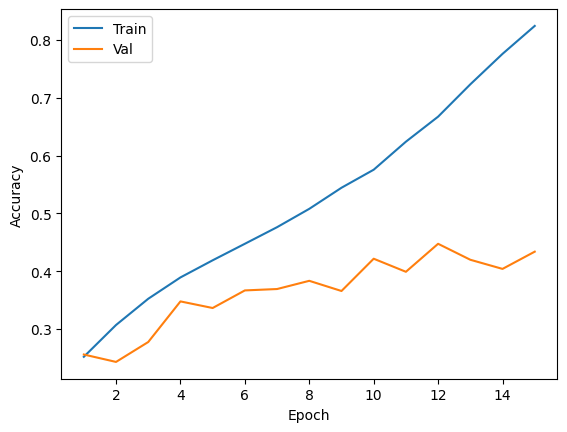

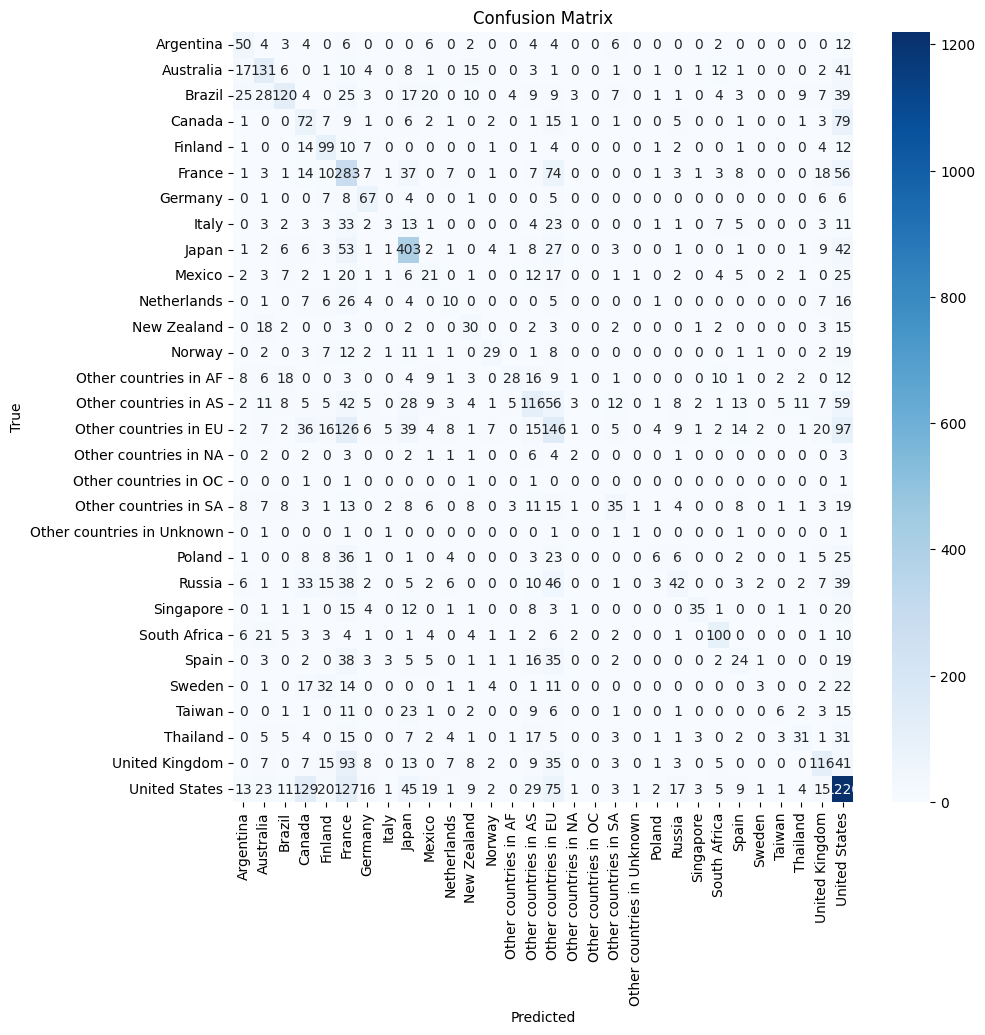

In [ ]:
# plot train vs val acc
from torchvision import models, transforms
num_classes = len(train_df["country"].unique())
class ResNet50Baseline(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        self.model = models.resnet50(pretrained=pretrained)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

#model = ResNet50Baseline(num_classes=num_classes, pretrained=True).to(DEVICE)
# import resnet50_baseline.pt to resume training
model = ResNet50Baseline(num_classes=num_classes, pretrained=False).to(DEVICE)

if os.path.exists("resnet50_full_training_log.csv"):
    df_log = pd.read_csv("resnet50_full_training_log.csv")

if os.path.exists("resnet50_trained.pt"):
    model.load_state_dict(torch.load("resnet50_trained.pt"))
    model.eval()

plt.plot(df_log[df_log['phase'] == 'train']['epoch'], df_log[df_log['phase'] == 'train']['acc'], label='Train')
plt.plot(df_log[df_log['phase'] == 'val']['epoch'], df_log[df_log['phase'] == 'val']['acc'], label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# get test acc and plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
model.eval()
test_preds = []
test_labels = []
correct_top1, correct_top3, total = 0, 0, 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE, dtype=torch.long)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        correct_top1 += (preds == labels).sum().item()
        correct_top3 += topk_accuracy(outputs, labels, k=3)
        total += labels.size(0)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

print(f"Test Top-1 Acc: {correct_top1/total:.4f}, "
      f"Top-3 Acc: {correct_top3/total:.4f}")

# confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Okay so we got about 43% accuracy now... honestly not too bad. I probably couldn't do better than that if I was just looking at the images. We also see that it's far more confident in predicitng other classes. Other countries in AS and EU tend to be the worst when it comes to predictions.

In [ ]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(test_labels, test_preds, target_names=le.classes_))

                            precision    recall  f1-score   support

                 Argentina       0.35      0.49      0.40       103
                 Australia       0.45      0.51      0.48       256
                    Brazil       0.58      0.34      0.43       348
                    Canada       0.19      0.35      0.24       208
                   Finland       0.38      0.63      0.48       157
                    France       0.26      0.53      0.35       536
                   Germany       0.46      0.64      0.54       105
                     Italy       0.16      0.03      0.04       118
                     Japan       0.57      0.70      0.63       576
                    Mexico       0.18      0.16      0.17       135
               Netherlands       0.18      0.11      0.14        87
               New Zealand       0.29      0.36      0.32        83
                    Norway       0.53      0.29      0.37       101
     Other countries in AF       0.64      0.21

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## StreetClip Zero-Shot Validation

Ok so here we are using StreetClip as a zero-shot model. Essentially, we don't need to train ANYTHING. We just give it a prompt and ask it to fill in the blank with the best labels. No training required.

In [ ]:
import torch
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Basic settings
IMAGE_ROOT = path  # update with your image folder path
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load StreetCLIP model + processor
print("Loading StreetCLIP...")
clip_model = CLIPModel.from_pretrained("geolocal/StreetCLIP").to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained("geolocal/StreetCLIP")

# Dataset wrapper for our test images
class GeoZeroShotDataset(Dataset):
    def __init__(self, df, img_root, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_root = img_root
        self.transform = transform  # not used but kept for flexibility

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_name = row["img_path"].replace("geoguessr_data/", "")
        full_path = os.path.join(self.img_root, file_name)
        image = Image.open(full_path).convert("RGB")
        return image, row["label"], row["country"]

# Data loader (custom collate since each sample includes a PIL Image)
zero_shot_dataset = GeoZeroShotDataset(test_df, IMAGE_ROOT)
zero_shot_loader = DataLoader(
    zero_shot_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=lambda x: x
)

# Turn class labels into CLIP text prompts
class_names = le.classes_
text_prompts = [f"A street view photo taken in {name}" for name in class_names]

text_inputs = clip_processor(text=text_prompts, return_tensors="pt", padding=True).to(DEVICE)

# Precompute text features once
with torch.no_grad():
    text_features = clip_model.get_text_features(**text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Zero-shot prediction loop
top1_correct = 0
top3_correct = 0
total = 0
true_labels = []
pred_labels = []

print("Running zero-shot inference...")
for batch in tqdm(zero_shot_loader):
    images, labels, _ = zip(*batch)

    # CLIP can directly process a list of PIL images
    inputs = clip_processor(images=list(images), return_tensors="pt", padding=True).to(DEVICE)

    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        logits = image_features @ text_features.T
        probs = logits.softmax(dim=-1)

        top1 = probs.argmax(dim=-1)
        _, top3 = probs.topk(3, dim=-1)

    labels = torch.tensor(labels).to(DEVICE)
    top1_correct += (top1 == labels).sum().item()
    total += labels.size(0)

    true_labels.extend(labels)
    pred_labels.extend(top1)

    # Manual top-3 check
    for i in range(labels.size(0)):
        if labels[i].item() in top3[i]:
            top3_correct += 1

print("\nZero-Shot Results:")
print(f"Top-1 Accuracy: {top1_correct/total:.4f}")
print(f"Top-3 Accuracy: {top3_correct/total:.4f}")


Loading StreetCLIP for zero-shot inference...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

Running zero-shot predictions...



100%|██████████| 469/469 [18:57<00:00,  2.43s/it]


Zero-Shot Results:
Top-1 Accuracy: 0.7300
Top-3 Accuracy: 0.9144


Wow it performs so much better. Already at 72% accuracy.

In [ ]:
# classification report
# Convert to CPU + NumPy before using classification_report
def to_numpy_safe(x):
    """Safely convert tensor (or list of tensors) to numpy array on CPU."""
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    elif isinstance(x, (list, tuple)):
        tensors = []
        for t in x:
            if torch.is_tensor(t):
                tensors.append(t.detach().cpu())
            else:
                tensors.append(torch.tensor(t))
        return torch.stack(tensors).numpy()  # <-- stack instead of cat
    else:
        return np.array(x)


# Convert safely
true_labels_np = to_numpy_safe(true_labels)
pred_labels_np = to_numpy_safe(pred_labels)

# Print classification report
print(classification_report(true_labels_np, pred_labels_np, target_names=class_names))


                            precision    recall  f1-score   support

                 Argentina       0.55      0.83      0.66       103
                 Australia       0.94      0.94      0.94       256
                    Brazil       0.91      0.88      0.89       348
                    Canada       0.68      0.89      0.77       208
                   Finland       0.69      0.85      0.77       157
                    France       0.91      0.82      0.86       536
                   Germany       0.62      0.76      0.68       105
                     Italy       0.63      0.80      0.70       118
                     Japan       0.97      0.92      0.94       576
                    Mexico       0.67      0.81      0.74       135
               Netherlands       0.79      0.85      0.82        87
               New Zealand       0.87      0.94      0.90        83
                    Norway       0.82      0.88      0.85       101
     Other countries in AF       0.05      0.13

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## StreetClip + MLP Validation

Now, we are adding a couple NN layers and actually training the model. We keep the StreetClip model the same, get embeddings for all the images, then use those embeddings as inputs the the NN.

In [5]:
# Load split metadata
geo_train = pd.read_csv("train_dataset.csv")
geo_val   = pd.read_csv("val_dataset.csv")
geo_test  = pd.read_csv("test_dataset.csv")

# Helper to load saved embedding checkpoints
def load_checkpoint(path):
    ckpt = torch.load(path, map_location="cpu")

    # Some checkpoints were saved as tuples, others as dicts
    if isinstance(ckpt, tuple):
        return ckpt
    if isinstance(ckpt, dict) and "embeddings" in ckpt and "labels" in ckpt:
        return ckpt["embeddings"], ckpt["labels"]

    raise ValueError("Unrecognized checkpoint format")

# Load precomputed StreetCLIP image embeddings
train_img_emb, _ = load_checkpoint("train_emb_StreetCLIP.pt")
val_img_emb, _   = load_checkpoint("val_emb_StreetCLIP.pt")
test_img_emb, _  = load_checkpoint("test_emb_StreetCLIP.pt")

# Replace labels from checkpoint with actual country labels
train_labels = geo_train["country"].values
val_labels   = geo_val["country"].values
test_labels  = geo_test["country"].values

# Encode country names as integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
val_labels   = le.transform(val_labels)
test_labels  = le.transform(test_labels)

# Convert embeddings into NumPy arrays
train_img_emb = np.array(train_img_emb)
val_img_emb   = np.array(val_img_emb)
test_img_emb  = np.array(test_img_emb)

print(f"Loaded StreetCLIP embeddings:")
print(f"  train {train_img_emb.shape}")
print(f"  val   {val_img_emb.shape}")
print(f"  test  {test_img_emb.shape}")


Loaded StreetCLIP embeddings:
  train (46795, 768)
  val   (5000, 768)
  test  (7500, 768)


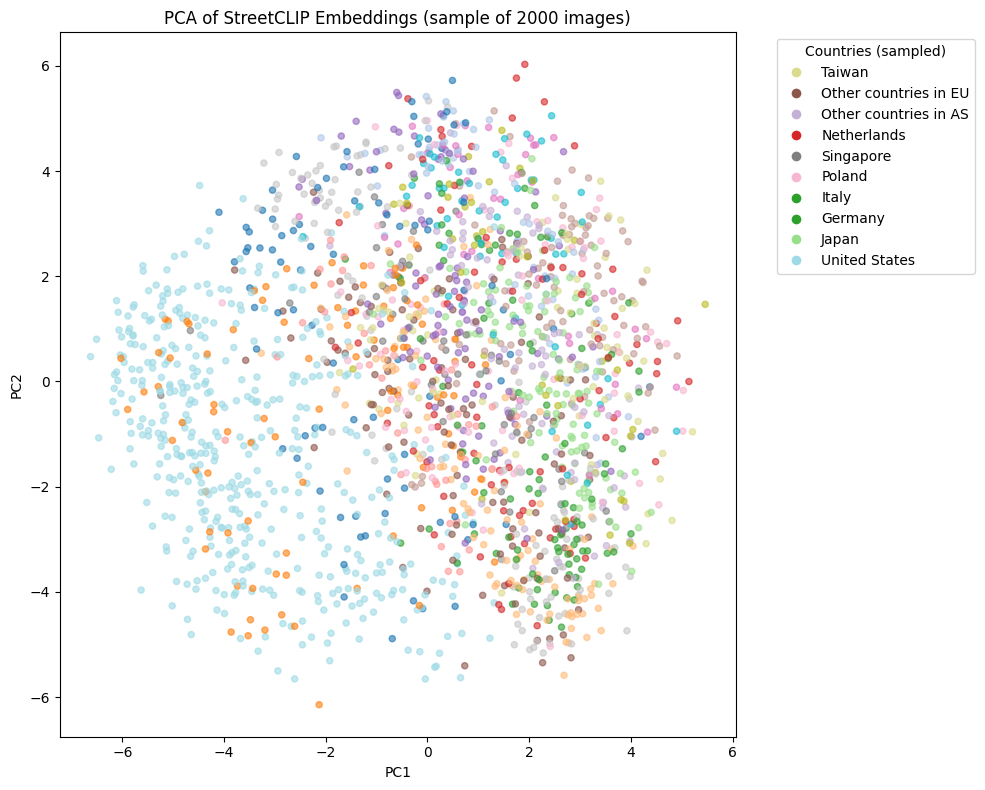

Two Principal Components Capture 13.894622802734375% variation in the data


In [ ]:
# Quick PCA to see if embeddings cluster by country
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random

# Randomly pick 2000 images from train set for visualization
idx = np.random.choice(len(train_img_emb), size=2000, replace=False)
X_sample = train_img_emb[idx]
y_sample = train_labels[idx]

# Reduce embeddings to 2 principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

# Plot the embeddings
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=y_sample, cmap='tab20', alpha=0.6, s=20)

# Add legend (only a subset of 10 countries for readability)
unique_labels = np.unique(y_sample)
subset_labels = random.sample(list(unique_labels), min(10, len(unique_labels)))
handles = []
for lbl in subset_labels:
    handles.append(plt.Line2D([], [], marker='o', color='w',
                              markerfacecolor=plt.cm.tab20(lbl / len(unique_labels)),
                              markersize=8, label=le.inverse_transform([lbl])[0]))
plt.legend(handles=handles, title="Countries (sampled)", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of StreetCLIP Embeddings (sample of 2000 images)")
plt.tight_layout()
plt.show()

# Show how much variance is captured by these two components
print(f"Two Principal Components Capture {pca.explained_variance_.sum()}% of variation in the data")


Epoch [10/200], Loss: 2.5439, Val Acc: 0.4784
Epoch [20/200], Loss: 1.5527, Val Acc: 0.7076
Epoch [30/200], Loss: 0.8330, Val Acc: 0.8088
Epoch [40/200], Loss: 0.5851, Val Acc: 0.8410
Epoch [50/200], Loss: 0.4917, Val Acc: 0.8640
Epoch [60/200], Loss: 0.4418, Val Acc: 0.8660
Epoch [70/200], Loss: 0.4092, Val Acc: 0.8694
Epoch [80/200], Loss: 0.3868, Val Acc: 0.8742
Epoch [90/200], Loss: 0.3694, Val Acc: 0.8788
Epoch [100/200], Loss: 0.3551, Val Acc: 0.8802
Epoch [110/200], Loss: 0.3432, Val Acc: 0.8818
Epoch [120/200], Loss: 0.3322, Val Acc: 0.8844
Epoch [130/200], Loss: 0.3225, Val Acc: 0.8862
Epoch [140/200], Loss: 0.3135, Val Acc: 0.8888
Epoch [150/200], Loss: 0.3053, Val Acc: 0.8878
Epoch [160/200], Loss: 0.2974, Val Acc: 0.8882
Epoch [170/200], Loss: 0.2910, Val Acc: 0.8874
Epoch [180/200], Loss: 0.2838, Val Acc: 0.8904
Epoch [190/200], Loss: 0.2778, Val Acc: 0.8908
Epoch [200/200], Loss: 0.2718, Val Acc: 0.8908


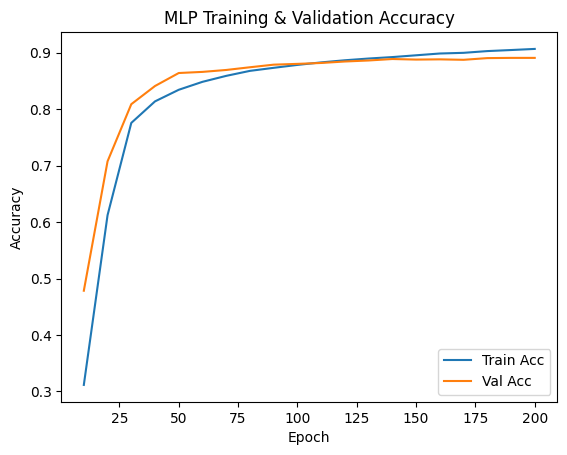

Top-1 Accuracy: 0.8813
Top-3 Accuracy: 0.9816
                            precision    recall  f1-score   support

                 Argentina       0.81      0.81      0.81       103
                 Australia       0.93      0.94      0.94       256
                    Brazil       0.92      0.92      0.92       348
                    Canada       0.86      0.82      0.84       208
                   Finland       0.83      0.87      0.85       157
                    France       0.87      0.90      0.88       536
                   Germany       0.90      0.79      0.84       105
                     Italy       0.69      0.74      0.71       118
                     Japan       0.97      0.98      0.97       576
                    Mexico       0.81      0.84      0.83       135
               Netherlands       0.83      0.84      0.83        87
               New Zealand       0.88      0.93      0.90        83
                    Norway       0.87      0.89      0.88       101
 

In [8]:

DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

# Simple MLP for StreetCLIP embeddings
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        layers = []
        in_size = input_size
        for h_size in hidden_sizes:
            layers.append(nn.Linear(in_size, h_size))
            layers.append(nn.ReLU())
            in_size = h_size
        layers.append(nn.Linear(in_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Use all embeddings from StreetCLIP
X_train, y_train = train_img_emb, train_labels
X_val, y_val = val_img_emb, val_labels
X_test, y_test = test_img_emb, test_labels

# Model configuration
input_size = X_train.shape[1]
hidden_sizes = [256, 128]
output_size = len(np.unique(y_train))

model = MLP(input_size, hidden_sizes, output_size).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 200
train_accuracies, val_accuracies = [], []

# Training loop
for epoch in range(num_epochs):
    model.train()
    X_tensor = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
    y_tensor = torch.tensor(y_train, dtype=torch.long).to(DEVICE)

    optimizer.zero_grad()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()

    # Evaluate every 10 epochs
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
            y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(DEVICE)
            val_outputs = model(X_val_tensor)
            _, val_preds = torch.max(val_outputs, 1)
            val_acc = (val_preds == y_val_tensor).float().mean().item()
            train_acc = (outputs.argmax(dim=1) == y_tensor).float().mean().item()

            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Acc: {val_acc:.4f}")

# Plot training and validation accuracy
plt.plot(range(10, num_epochs+1, 10), train_accuracies, label='Train Acc')
plt.plot(range(10, num_epochs+1, 10), val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('MLP Training & Validation Accuracy')
plt.show()

# Test set evaluation
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(DEVICE)

    test_outputs = model(X_test_tensor)

    # Top-1 Accuracy
    _, top1_preds = torch.max(test_outputs, dim=1)
    top1_acc = (top1_preds == y_test_tensor).float().mean().item()

    # Top-3 Accuracy
    top3_preds = torch.topk(test_outputs, k=3, dim=1).indices
    top3_correct = top3_preds.eq(y_test_tensor.view(-1, 1)).any(dim=1)
    top3_acc = top3_correct.float().mean().item()

    # Classification report
    test_preds_np = top1_preds.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    report = classification_report(y_test_np, test_preds_np, target_names=le.classes_)

print(f"Top-1 Accuracy: {top1_acc:.4f}")
print(f"Top-3 Accuracy: {top3_acc:.4f}")
print(report)





Wowza it performs well and is not overfitting. Definitely best so far.

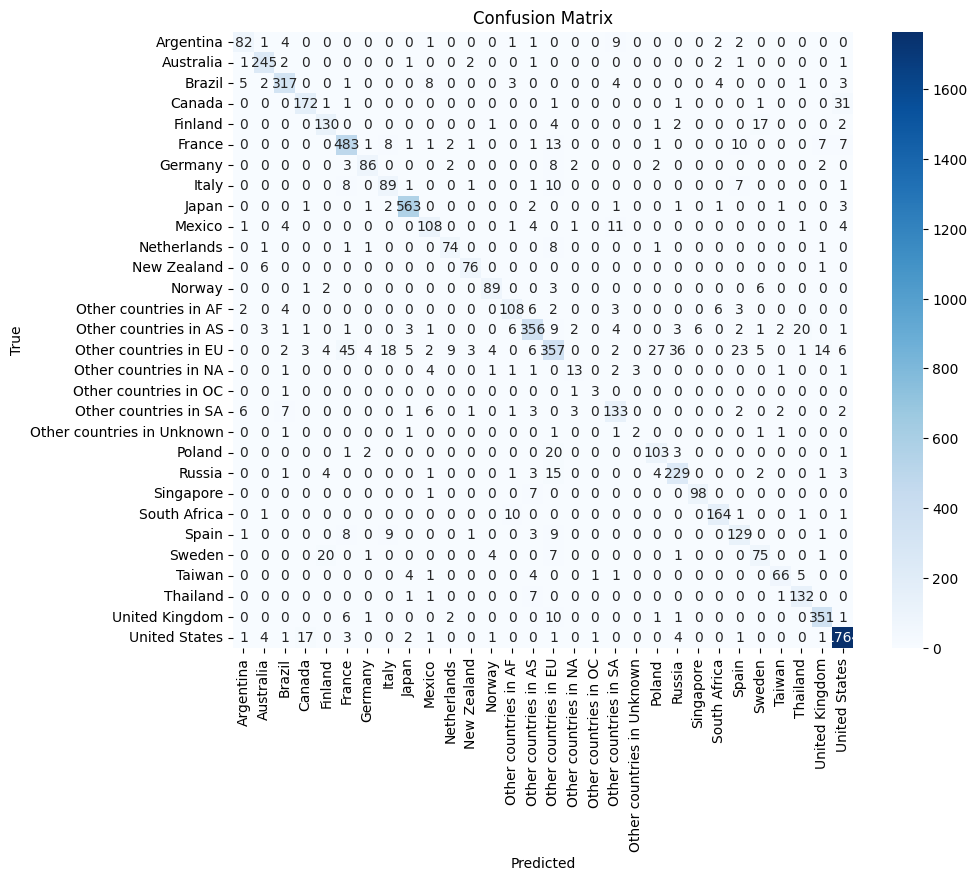

                            precision    recall  f1-score   support

                 Argentina       0.83      0.80      0.81       103
                 Australia       0.93      0.96      0.94       256
                    Brazil       0.92      0.91      0.91       348
                    Canada       0.88      0.83      0.85       208
                   Finland       0.81      0.83      0.82       157
                    France       0.86      0.90      0.88       536
                   Germany       0.89      0.82      0.85       105
                     Italy       0.71      0.75      0.73       118
                     Japan       0.97      0.98      0.97       576
                    Mexico       0.79      0.80      0.80       135
               Netherlands       0.83      0.85      0.84        87
               New Zealand       0.89      0.92      0.90        83
                    Norway       0.89      0.88      0.89       101
     Other countries in AF       0.82      0.81

In [ ]:
# Confusion Matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

y_test_np = y_test_tensor.cpu().numpy()
y_pred_np = test_preds.cpu().numpy()
class_names = le.classes_
plot_confusion_matrix(y_test_np, y_pred_np, class_names)

# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_np, y_pred_np, target_names=class_names))

It performs great across the board. It's worst class is predicting "Other in EU" (maybe add something to improve that at the end; time permitting). It is ridiculously accurate

## Idea: Train a Three-Label Classifier to Determine if the Picture Belongs to "Known Country in EU," "Other Country in EU," or Other.

In [9]:
geo_train

img_path  \
0      geoguessr_data/compressed_dataset/Russia/canva...   
1      geoguessr_data/compressed_dataset/Ireland/canv...   
2      geoguessr_data/compressed_dataset/Thailand/can...   
3      geoguessr_data/compressed_dataset/Spain/canvas...   
4      geoguessr_data/compressed_dataset/Germany/canv...   
...                                                  ...   
46790  geoguessr_data/augmented_train/Other countries...   
46791  geoguessr_data/augmented_train/Other countries...   
46792  geoguessr_data/augmented_train/Other countries...   
46793  geoguessr_data/augmented_train/Other countries...   
46794  geoguessr_data/augmented_train/Other countries...   

                     country continent         coarse_label  
0                     Russia        EU  Other Country in EU  
1      Other countries in EU        EU  Other Country in EU  
2                   Thailand        AS                Other  
3                      Spain        EU     Known EU Country  
4                    Germany        EU     Known EU Country  
...                      ...       ...                  ...  
46790  Other countries in OC       NaN                Other  
46791  Other countries in OC       NaN                Other  
46792  Other countries in OC       NaN                Other  
46793  Other countries in OC       NaN                Other  
46794  Other countries in OC       NaN                Other  

[46795 rows x 4 columns]

In [10]:


# Map countries to coarse categories for a simpler classification task
def map_coarse(row):
    country = row["country"]
    continent = row["continent"]

    if continent == "EU":
        if "Known" in country or country in ["France", "Portugal", "Spain", "Germany", "Italy"]:
            return "Known EU Country"
        else:
            return "Other Country in EU"
    else:
        return "Other"

# Apply coarse mapping to train, val, test datasets
geo_train["coarse_label"] = geo_train.apply(map_coarse, axis=1)
geo_val["coarse_label"] = geo_val.apply(map_coarse, axis=1)
geo_test["coarse_label"] = geo_test.apply(map_coarse, axis=1)

# Encode coarse labels
le_coarse = LabelEncoder()
y_train_coarse = le_coarse.fit_transform(geo_train["coarse_label"])
y_val_coarse = le_coarse.transform(geo_val["coarse_label"])
y_test_coarse = le_coarse.transform(geo_test["coarse_label"])

# Train a coarse classifier using the same StreetCLIP embeddings
coarse_model = MLP(input_size, hidden_sizes, len(le_coarse.classes_)).to(DEVICE)
optimizer_coarse = torch.optim.Adam(coarse_model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(200):
    coarse_model.train()
    X_tensor = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
    y_tensor = torch.tensor(y_train_coarse, dtype=torch.long).to(DEVICE)

    optimizer_coarse.zero_grad()
    outputs = coarse_model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer_coarse.step()

    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            val_logits = coarse_model(torch.tensor(X_val, dtype=torch.float32).to(DEVICE))
            val_acc = (val_logits.argmax(1).cpu().numpy() == y_val_coarse).mean()
        print(f"[Coarse] Epoch {epoch+1}/200 | Val Acc: {val_acc:.4f}")

# Function to get softmax probabilities from a model
def get_probs(model, X):
    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(X, dtype=torch.float32).to(DEVICE))
        return F.softmax(logits, dim=1).cpu().numpy()

# Get probabilities from both fine and coarse models
train_probs_fine = get_probs(model, X_train)
val_probs_fine = get_probs(model, X_val)
test_probs_fine = get_probs(model, X_test)

train_probs_coarse = get_probs(coarse_model, X_train)
val_probs_coarse = get_probs(coarse_model, X_val)
test_probs_coarse = get_probs(coarse_model, X_test)

# Stack fine + coarse probabilities to create input for meta-MLP
X_train_stack = np.hstack([train_probs_fine, train_probs_coarse])
X_val_stack = np.hstack([val_probs_fine, val_probs_coarse])
X_test_stack = np.hstack([test_probs_fine, test_probs_coarse])

# Define and train meta-MLP
meta_input_size = X_train_stack.shape[1]
meta_model = MLP(meta_input_size, [64,16], output_size).to(DEVICE)
optimizer_meta = torch.optim.Adam(meta_model.parameters(), lr=0.001)
criterion_meta = torch.nn.CrossEntropyLoss()

for epoch in range(500):
    meta_model.train()
    X_tensor = torch.tensor(X_train_stack, dtype=torch.float32).to(DEVICE)
    y_tensor = torch.tensor(y_train, dtype=torch.long).to(DEVICE)

    optimizer_meta.zero_grad()
    outputs = meta_model(X_tensor)
    loss = criterion_meta(outputs, y_tensor)
    loss.backward()
    optimizer_meta.step()

    if (epoch + 1) % 10 == 0:
        meta_model.eval()
        with torch.no_grad():
            val_out = meta_model(torch.tensor(X_val_stack, dtype=torch.float32).to(DEVICE))
            val_acc = (val_out.argmax(1).cpu().numpy() == y_val).mean()
        print(f"[Meta-MLP] Epoch {epoch+1}/500 | Val Acc: {val_acc:.4f}")

# Evaluate the ensemble on the test set
meta_model.eval()
with torch.no_grad():
    test_out = meta_model(torch.tensor(X_test_stack, dtype=torch.float32).to(DEVICE))
    test_preds = test_out.argmax(1).cpu().numpy()
    test_acc = (test_preds == y_test).mean()

print(f" Ensemble Test Accuracy: {test_acc:.4f}")



[Coarse] Epoch 10/200 | Val Acc: 0.7154
[Coarse] Epoch 20/200 | Val Acc: 0.9058
[Coarse] Epoch 30/200 | Val Acc: 0.9402
[Coarse] Epoch 40/200 | Val Acc: 0.9496
[Coarse] Epoch 50/200 | Val Acc: 0.9536
[Coarse] Epoch 60/200 | Val Acc: 0.9542
[Coarse] Epoch 70/200 | Val Acc: 0.9564
[Coarse] Epoch 80/200 | Val Acc: 0.9574
[Coarse] Epoch 90/200 | Val Acc: 0.9588
[Coarse] Epoch 100/200 | Val Acc: 0.9602
[Coarse] Epoch 110/200 | Val Acc: 0.9606
[Coarse] Epoch 120/200 | Val Acc: 0.9612
[Coarse] Epoch 130/200 | Val Acc: 0.9620
[Coarse] Epoch 140/200 | Val Acc: 0.9620
[Coarse] Epoch 150/200 | Val Acc: 0.9632
[Coarse] Epoch 160/200 | Val Acc: 0.9638
[Coarse] Epoch 170/200 | Val Acc: 0.9640
[Coarse] Epoch 180/200 | Val Acc: 0.9636
[Coarse] Epoch 190/200 | Val Acc: 0.9640
[Coarse] Epoch 200/200 | Val Acc: 0.9644
[Meta-MLP] Epoch 10/500 | Val Acc: 0.0138
[Meta-MLP] Epoch 20/500 | Val Acc: 0.0138
[Meta-MLP] Epoch 30/500 | Val Acc: 0.3086
[Meta-MLP] Epoch 40/500 | Val Acc: 0.3096
[Meta-MLP] Epoch 50/5

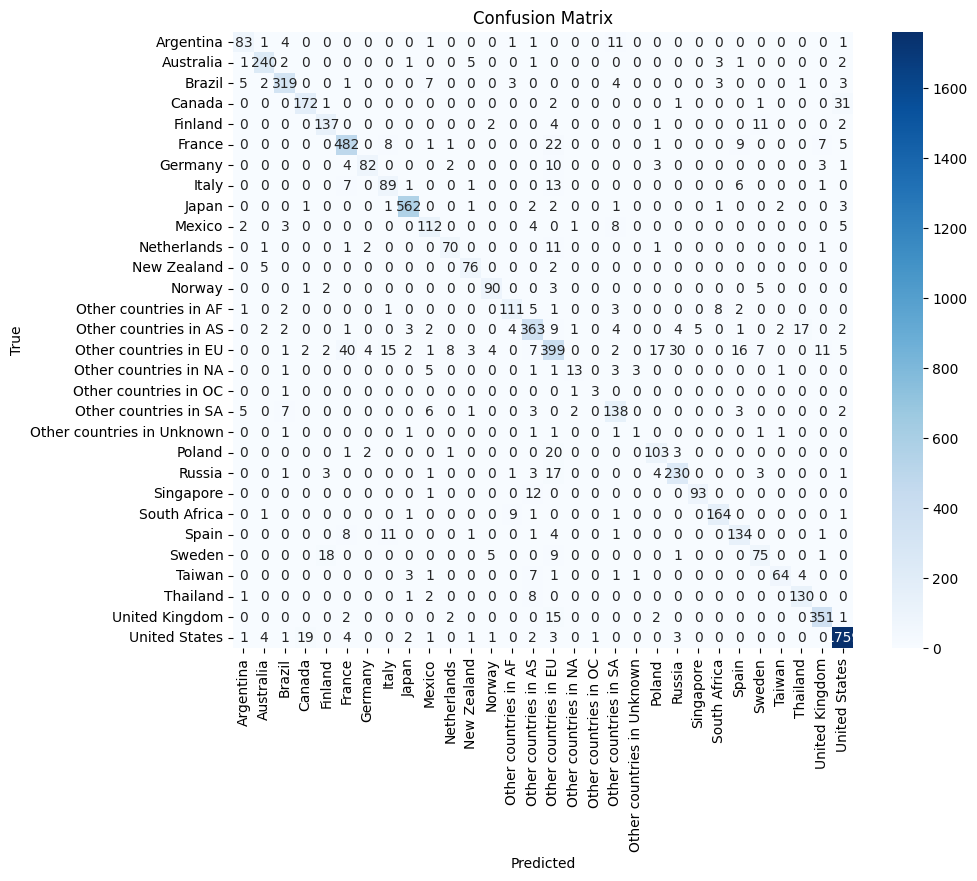

In [11]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

y_test_np = y_test#_tensor.cpu().numpy()
y_pred_np = test_preds#.cpu().numpy()
class_names = le.classes_
plot_confusion_matrix(y_test_np, y_pred_np, class_names)

In [ ]:
## classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_np, y_pred_np, target_names=class_names))

                            precision    recall  f1-score   support

                 Argentina       0.83      0.78      0.80       103
                 Australia       0.94      0.96      0.95       256
                    Brazil       0.91      0.91      0.91       348
                    Canada       0.88      0.81      0.85       208
                   Finland       0.82      0.84      0.83       157
                    France       0.88      0.90      0.89       536
                   Germany       0.92      0.79      0.85       105
                     Italy       0.72      0.75      0.73       118
                     Japan       0.97      0.98      0.97       576
                    Mexico       0.80      0.81      0.80       135
               Netherlands       0.86      0.82      0.84        87
               New Zealand       0.89      0.92      0.90        83
                    Norway       0.89      0.88      0.89       101
     Other countries in AF       0.83      0.82

--Next: sample ones that we got wrong and see if adding a caption wouldve helped.

## StreetClipMLP + Human Captioning to See if Errors Improve

I manually added captions to about 750 images, about half in training set and half in test set. Most of them were on missclassified images from our previous classifier. We want to see if having captions for those images would've helped. We use a pretrained transformer to get embeddings for the captions that can be fed into the MLP.

Note that it's hard to say for sure if doing such a task would actually improve performance since it's only on a subset of data.

In [13]:


# Read the raw text file (replace with actual filename if needed)
with open("image captions.txt", "r") as f:
    text = f.read()

# Match filename + caption pattern
pattern = r"([A-Za-z0-9_]+\.jpg):\s*(.+?)(?=\n[A-Za-z0-9_]+\.jpg:|\Z)"
matches = re.findall(pattern, text, flags=re.S)

# Convert to DataFrame
captions_df = pd.DataFrame(matches, columns=["img_name", "caption"])

# Optional: clean whitespace
captions_df["caption"] = captions_df["caption"].str.strip()

# drop duplicates from captions_df based on img_name
captions_df = captions_df.drop_duplicates(subset=["img_name"])

captions_df.to_csv("human_captions.csv", index=False)
print(f"Extracted {len(captions_df)} captions.")
captions_df.head()

Extracted 736 captions.


img_name  \
0  Argentina_106_canvas_1629618179.jpg   
1  Argentina_155_canvas_1630050448.jpg   
2                canvas_1629258580.jpg   
3                canvas_1629265415.jpg   
4                canvas_1629267368.jpg   

                                             caption  
0  moped riding on left side of road, neighborhoo...  
1  Palm trees, dry grass, light poles, tan-ish st...  
2  bridge underpass, cars driving on right side, ...  
3  tree-lined road, maybe highway, white lines be...  
4  Traffic signs: None visible.\nRoad markings: S...

In [14]:
geo_train = pd.read_csv("train_dataset.csv")
geo_val = pd.read_csv("val_dataset.csv")
geo_test = pd.read_csv("test_dataset.csv")

for df in [geo_train, geo_val, geo_test]:
    df["img_name"] = df["img_path"].apply(lambda x: os.path.basename(x))

geo_train = geo_train.merge(captions_df, on="img_name", how="left")
geo_val = geo_val.merge(captions_df, on="img_name", how="left")
geo_test = geo_test.merge(captions_df, on="img_name", how="left")

print(f"Caption coverage: train={geo_train['caption'].notna().mean():.2%}, val={geo_val['caption'].notna().mean():.2%}, test={geo_test['caption'].notna().mean():.2%}")

Caption coverage: train=0.87%, val=6.56%, test=0.00%


In [15]:
# LOAD STREETCLIP EMBEDDINGS
def load_checkpoint(path):
    ckpt = torch.load(path, map_location="cpu")
    if isinstance(ckpt, tuple):
        return ckpt
    elif isinstance(ckpt, dict) and "embeddings" in ckpt and "labels" in ckpt:
        return ckpt["embeddings"], ckpt["labels"]
    else:
        raise ValueError("Checkpoint format not recognized")

train_img_emb, train_labels = load_checkpoint("train_emb_StreetCLIP.pt")
val_img_emb, val_labels = load_checkpoint("val_emb_StreetCLIP.pt")
test_img_emb, test_labels = load_checkpoint("test_emb_StreetCLIP.pt")

# redefine train_labels, val_labels, test_labels as the country labels from geo_train, geo_val, geo_test
train_labels = geo_train["country"].values
val_labels = geo_val["country"].values
test_labels = geo_test["country"].values

# label encode the labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
val_labels = le.transform(val_labels)
test_labels = le.transform(test_labels)

train_img_emb = np.array(train_img_emb)
val_img_emb = np.array(val_img_emb)
test_img_emb = np.array(test_img_emb)

print(f"Loaded StreetCLIP embeddings: train={train_img_emb.shape}, val={val_img_emb.shape}, test={test_img_emb.shape}")

Loaded StreetCLIP embeddings: train=(46795, 768), val=(5000, 768), test=(7500, 768)


In [16]:
# GENERATE CAPTION EMBEDDINGS

text_model = SentenceTransformer("all-MiniLM-L6-v2", device=DEVICE)

def get_caption_embeds(df):
    texts = df["caption"].fillna("").tolist()
    embs = text_model.encode(texts, convert_to_numpy=True, show_progress_bar=True)
    return embs

train_txt_emb = get_caption_embeds(geo_train)
val_txt_emb = get_caption_embeds(geo_val)
test_txt_emb = get_caption_embeds(geo_test)

# Make sure the folder exists
os.makedirs("outputs", exist_ok=True)

# Save for re-use
np.save("outputs/train_caption_emb.npy", train_txt_emb)
np.save("outputs/val_caption_emb.npy", val_txt_emb)
np.save("outputs/test_caption_emb.npy", test_txt_emb)

print("Caption embeddings generated and saved.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1463 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/235 [00:00<?, ?it/s]

Caption embeddings generated and saved.


In [17]:

# Merge embeddings

X_train_no_text = np.concatenate([train_img_emb, np.zeros_like(train_txt_emb)], axis=1)
X_val_no_text = np.concatenate([val_img_emb, np.zeros_like(val_txt_emb)], axis=1)
X_test_no_text = np.concatenate([test_img_emb, np.zeros_like(test_txt_emb)], axis=1)

# Include caption embeddings (augment dimensionality)
X_train_with_text = np.concatenate([train_img_emb, train_txt_emb], axis=1)
X_val_with_text = np.concatenate([val_img_emb, val_txt_emb], axis=1)
X_test_with_text = np.concatenate([test_img_emb, test_txt_emb], axis=1)

y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

print(f"Merged embeddings: train_with_text={X_train_with_text.shape}, test_with_text={X_test_with_text.shape}")

Merged embeddings: train_with_text=(46795, 1152), test_with_text=(7500, 1152)


In [18]:
# train baseline vs augmented MLP

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, log_loss
def train_mlp(X_train, y_train, X_eval, y_eval):
    clf = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_eval)
    y_proba = clf.predict_proba(X_eval)
    acc = accuracy_score(y_eval, y_pred)
    loss = log_loss(y_eval, y_proba)
    return clf, acc, loss, y_proba



print("Training baseline model (StreetCLIP only)...")
clf_base, acc_base, loss_base, proba_base = train_mlp(X_val_no_text, y_val, X_test_no_text, y_test)
print(f"Baseline — Accuracy: {acc_base:.4f}, Log Loss: {loss_base:.4f}")

print("\nTraining augmented model (StreetCLIP + Captions)...")
clf_aug, acc_aug, loss_aug, proba_aug = train_mlp(X_val_with_text, y_val, X_test_with_text, y_test)
print(f"Augmented — Accuracy: {acc_aug:.4f}, Log Loss: {loss_aug:.4f}")

Training baseline model (StreetCLIP only)...
Baseline — Accuracy: 0.8581, Log Loss: 0.8103

Training augmented model (StreetCLIP + Captions)...
Augmented — Accuracy: 0.8605, Log Loss: 0.7915


In [19]:
# Do the same as above but using PyTorch MLP for evaluation consistency
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        layers = []
        in_size = input_size
        for h_size in hidden_sizes:
            layers.append(nn.Linear(in_size, h_size))
            layers.append(nn.ReLU())
            in_size = h_size
        layers.append(nn.Linear(in_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)



# Training function
def train_model(X_train, y_train, num_epochs=300, lr=0.001, X_val=None, y_val=None):
    model = MLP(input_size, hidden_sizes, output_size).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        model.train()
        X_tensor = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
        y_tensor = torch.tensor(y_train, dtype=torch.long).to(DEVICE)

        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

            # print eval results after every 10 epochs
            eval_acc, eval_loss = evaluate_model(model, X_val, y_val)
            print(f"  → Eval Acc: {eval_acc:.4f}, Eval Loss: {eval_loss:.4f}")

    return model

def evaluate_model(model, X_eval, y_eval):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X_eval, dtype=torch.float32).to(DEVICE)
        y_tensor = torch.tensor(y_eval, dtype=torch.long).to(DEVICE)
        outputs = model(X_tensor)
        _, preds = torch.max(outputs, 1)
        acc = (preds == y_tensor).float().mean().item()
        # also compute loss as - confidence for true class
        outputs_softmax = nn.Softmax(dim=1)(outputs)
        true_class_confidence = outputs_softmax.gather(1, y_tensor.unsqueeze(1)).squeeze()
        loss = -true_class_confidence.mean().item()

        return acc, loss
# Train baseline model (StreetCLIP only)
input_size = X_train_no_text.shape[1]
hidden_sizes = [264, 128, 64]
output_size = len(np.unique(y_train))
print("Training baseline model (StreetCLIP only)...")
model_base = train_model(X_train_no_text, y_train, num_epochs=200, lr=0.001, X_val=X_val_no_text, y_val=y_val)
# Train augmented model (StreetCLIP + Captions)
print("Training augmented model (StreetCLIP + Captions)...")
model_aug = train_model(X_train_with_text, y_train, num_epochs=200, lr=0.001, X_val=X_val_with_text, y_val=y_val)

# evaluate models with our function defined above



# Evaluate
acc_base, loss_base = evaluate_model(model_base, X_val_no_text, y_val)
acc_aug, loss_aug = evaluate_model(model_aug, X_val_with_text, y_val)

print(f"Base Model Accuracy (image only): {acc_base:.4f}")
print(f"Augmented Model Accuracy (image+caption): {acc_aug:.4f}")

print(f"Base Model Loss (negative confidence): {loss_base:.4f}")
print(f"Augmented Model Loss (negative confidence): {loss_aug:.4f}")




Training baseline model (StreetCLIP only)...
Epoch [10/200], Loss: 2.8738
  → Eval Acc: 0.2808, Eval Loss: -0.1376
Epoch [20/200], Loss: 2.0676
  → Eval Acc: 0.5316, Eval Loss: -0.3294
Epoch [30/200], Loss: 1.3141
  → Eval Acc: 0.7208, Eval Loss: -0.4944
Epoch [40/200], Loss: 0.8441
  → Eval Acc: 0.7988, Eval Loss: -0.6562
Epoch [50/200], Loss: 0.6370
  → Eval Acc: 0.8318, Eval Loss: -0.7393
Epoch [60/200], Loss: 0.5335
  → Eval Acc: 0.8450, Eval Loss: -0.7718
Epoch [70/200], Loss: 0.4788
  → Eval Acc: 0.8560, Eval Loss: -0.7872
Epoch [80/200], Loss: 0.4409
  → Eval Acc: 0.8622, Eval Loss: -0.7979
Epoch [90/200], Loss: 0.4147
  → Eval Acc: 0.8656, Eval Loss: -0.8034
Epoch [100/200], Loss: 0.3948
  → Eval Acc: 0.8662, Eval Loss: -0.8080
Epoch [110/200], Loss: 0.3788
  → Eval Acc: 0.8716, Eval Loss: -0.8125
Epoch [120/200], Loss: 0.3664
  → Eval Acc: 0.8760, Eval Loss: -0.8158
Epoch [130/200], Loss: 0.3553
  → Eval Acc: 0.8766, Eval Loss: -0.8200
Epoch [140/200], Loss: 0.3457
  → Eval Ac

Ok so essentially the same results, which makes sense since there are only captions for like 350 images in train and val.

In [ ]:
# Look at performance of both models on misclassified val samples
# The missclassified sample images are in missclassified_samples/val; get their img_paths then get their indices
misclassified_indices = []
df_misclassified = pd.read_csv("misclassified_val_images.csv")

for img_name in df_misclassified["img_name"]:
     img_path = img_name  # just the file name
     # find index in geo_val where img_path matches
     idx = geo_val[geo_val["img_name"] == img_path].index
     #idx = geo_val[geo_val["img_name"] == img_path].index.tolist()
     if len(idx) > 0:
         misclassified_indices.append(idx[0])
# get X_val_no_text and X_val_with_text for these indices

X_misclassified_no_text = X_val_no_text[misclassified_indices]
X_misclassified_with_text = X_val_with_text[misclassified_indices]
y_misclassified = y_val[misclassified_indices]
# evaluate both models on these samples
acc_base_mis, loss_base_mis = evaluate_model(model_base, X_misclassified_no_text, y_misclassified)
acc_aug_mis, loss_aug_mis = evaluate_model(model_aug, X_misclassified_with_text, y_misclassified)
print(f"Base Model on Misclassified Samples - Accuracy: {acc_base_mis:.4f}, Loss: {loss_base_mis:.4f}")
print(f"Augmented Model on Misclassified Samples - Accuracy: {acc_aug_mis:.4f}, Loss: {loss_aug_mis:.4f}")

df_val_images = pd.read_csv("sampled_val_images.csv")

other_text_indices = []

for img_name in df_val_images["img_name"]:
     img_path = img_name
     idx = geo_val[geo_val["img_name"] == img_path].index
     if len(idx) > 0:
         other_text_indices.append(idx[0])
# get X_val_no_text and X_val_with_text for these indices

X_val_other_no_text = X_val_no_text[other_text_indices]
X_val_other_with_text = X_val_with_text[other_text_indices]
y_val_other = y_val[other_text_indices]
# evaluate both models on these samples
acc_base_mis, loss_base_mis = evaluate_model(model_base, X_val_other_no_text, y_val_other)
acc_aug_mis, loss_aug_mis = evaluate_model(model_aug, X_val_other_with_text, y_val_other)
print(f"Base Model on other Text Samples - Accuracy: {acc_base_mis:.4f}, Loss: {loss_base_mis:.4f}")
print(f"Augmented Model on other Text Samples - Accuracy: {acc_aug_mis:.4f}, Loss: {loss_aug_mis:.4f}")


Base Model on Misclassified Samples - Accuracy: 0.1520, Loss: -0.2099
Augmented Model on Misclassified Samples - Accuracy: 0.1400, Loss: -0.1993
Base Model on other Text Samples - Accuracy: 0.9300, Loss: -0.8659
Augmented Model on other Text Samples - Accuracy: 0.9000, Loss: -0.8492


After breaking out the results, they appear to be essentially the same for both.

## Training on ONLY the images with captions
(We expect poor results because this is only a few hundred images! Just want to see if adding the captions improves the model when training set is small)

In [ ]:
# using pytorch instead of sklearn MLPClassifier
np.random.seed(42)
torch.manual_seed(42)
import torch
import torch.nn as nn
import torch.optim as optim
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        layers = []
        last_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(last_size, hidden_size))
            layers.append(nn.ReLU())
            last_size = hidden_size
        layers.append(nn.Linear(last_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


# Base Model
input_size = X_train_with_text.shape[1]
hidden_sizes = [256, 128]
output_size = len(np.unique(y_train))
model = MLP(input_size, hidden_sizes, output_size).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    inputs = torch.tensor(X_val_with_text, dtype=torch.float32).to(DEVICE)
    labels = torch.tensor(y_val, dtype=torch.long).to(DEVICE)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 2 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Find the portion of training set with captions
train_with_captions_mask = geo_train["caption"].notna().values
X_train_with_captions = X_train_with_text[train_with_captions_mask]
y_train_with_captions = y_train[train_with_captions_mask]

# sample 100 random samples from X_train_with_captions and y_train_with_captions for quicker training
sample_indices = np.random.choice(len(X_train_with_captions), size=300, replace=False)
X_train_sampled = X_train_with_captions[sample_indices]
y_train_sampled = y_train_with_captions[sample_indices]

# Augmented Model
model_aug = MLP(input_size, hidden_sizes, output_size).to(DEVICE)

# Compare new model error and loss vs old model on other samples with captions
X_eval = X_train_with_captions[~np.isin(np.arange(len(X_train_with_captions)), sample_indices)]
y_eval = y_train_with_captions[~np.isin(np.arange(len(y_train_with_captions)), sample_indices)]

print(f"Training with {len(X_train_sampled)} samples and evaluating on {len(X_eval)} samples")

# set embeddings without text to zero
X_eval0 = X_eval.copy()
X_eval0[:, train_img_emb.shape[1]:] = 0

criterion = nn.CrossEntropyLoss()
optimizer_aug = optim.Adam(model_aug.parameters(), lr=0.001)
num_epochs = 200
for epoch in range(num_epochs):
    model_aug.train()
    inputs = torch.tensor(X_train_sampled, dtype=torch.float32).to(DEVICE)
    labels = torch.tensor(y_train_sampled, dtype=torch.long).to(DEVICE)

    optimizer_aug.zero_grad()
    outputs = model_aug(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer_aug.step()

    if (epoch+1) % 2 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate both models
model.eval()
model_aug.eval()
with torch.no_grad():
    inputs_base = torch.tensor(X_eval0, dtype=torch.float32).to(DEVICE)
    labels_eval = torch.tensor(y_eval, dtype=torch.long).to(DEVICE)
    outputs_base = model(inputs_base)
    _, predicted_base = torch.max(outputs_base, 1)
    acc_base_eval = (predicted_base == labels_eval).float().mean().item()

    inputs_aug = torch.tensor(X_eval, dtype=torch.float32).to(DEVICE)
    outputs_aug = model_aug(inputs_aug)
    _, predicted_aug = torch.max(outputs_aug, 1)
    acc_aug_eval = (predicted_aug == labels_eval).float().mean().item()
print(f"Evaluation Accuracy - Base Model: {acc_base_eval:.4f}, Augmented Model: {acc_aug_eval:.4f}")


Epoch [2/5], Loss: 3.3043
Epoch [4/5], Loss: 3.0211
Training with 300 samples and evaluating on 107 samples
Epoch [2/200], Loss: 3.3419
Epoch [4/200], Loss: 3.1945
Epoch [6/200], Loss: 3.0094
Epoch [8/200], Loss: 2.8458
Epoch [10/200], Loss: 2.6660
Epoch [12/200], Loss: 2.4605
Epoch [14/200], Loss: 2.2465
Epoch [16/200], Loss: 2.0300
Epoch [18/200], Loss: 1.8214
Epoch [20/200], Loss: 1.6275
Epoch [22/200], Loss: 1.4525
Epoch [24/200], Loss: 1.2963
Epoch [26/200], Loss: 1.1552
Epoch [28/200], Loss: 1.0311
Epoch [30/200], Loss: 0.9197
Epoch [32/200], Loss: 0.8193
Epoch [34/200], Loss: 0.7277
Epoch [36/200], Loss: 0.6450
Epoch [38/200], Loss: 0.5675
Epoch [40/200], Loss: 0.4957
Epoch [42/200], Loss: 0.4307
Epoch [44/200], Loss: 0.3717
Epoch [46/200], Loss: 0.3189
Epoch [48/200], Loss: 0.2718
Epoch [50/200], Loss: 0.2305
Epoch [52/200], Loss: 0.1943
Epoch [54/200], Loss: 0.1631
Epoch [56/200], Loss: 0.1364
Epoch [58/200], Loss: 0.1140
Epoch [60/200], Loss: 0.0952
Epoch [62/200], Loss: 0.07

Takeaway: the captions did not help with the main model trained on ~50K images but with small samples (with a few hundred or so images) there is significant help 8% -> 40% accuracy. Overall recommendation: just stick to streetclip. Captions, unless automatic, don't provide much lift

Added a sample of no captions in with training and that helped the base model considerably. Still the augmented model performs better but really it's not crazy.

## Hierarchical Model

In [23]:


# use GPU if available, else mps (apple), else CPU
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
os.makedirs("checkpoints", exist_ok=True)

# load datasets + embeddings
geo_train = pd.read_csv("train_dataset.csv")
geo_val = pd.read_csv("val_dataset.csv")
geo_test = pd.read_csv("test_dataset.csv")

def load_checkpoint(path):
    ckpt = torch.load(path, map_location="cpu")
    if isinstance(ckpt, tuple):
        return ckpt
    elif isinstance(ckpt, dict) and "embeddings" in ckpt and "labels" in ckpt:
        return ckpt["embeddings"], ckpt["labels"]
    else:
        raise ValueError("checkpoint format not recognized")

train_emb, _ = load_checkpoint("train_emb_StreetCLIP.pt")
val_emb, _ = load_checkpoint("val_emb_StreetCLIP.pt")
test_emb, _ = load_checkpoint("test_emb_StreetCLIP.pt")

train_emb, val_emb, test_emb = np.array(train_emb), np.array(val_emb), np.array(test_emb)


coarse_le = LabelEncoder()
train_coarse = coarse_le.fit_transform(geo_train["continent"])
val_coarse = coarse_le.transform(geo_val["continent"])
test_coarse = coarse_le.transform(geo_test["continent"])

# encode labels for fine (country) and coarse (continent)
fine_le = LabelEncoder()
train_fine = fine_le.fit_transform(geo_train["country"])
val_fine = fine_le.transform(geo_val["country"])
test_fine = fine_le.transform(geo_test["country"])

# simple MLP with relu and dropout
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout=0.2):
        super(MLP, self).__init__()
        layers = []
        in_size = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(in_size, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_size = h
        layers.append(nn.Linear(in_size, output_size))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# train an mlp on given data
def train_mlp(X_train, y_train, X_val, y_val, num_classes, save_path, model_name, epochs=100, lr=1e-3):
    input_size = X_train.shape[1]
    model = MLP(input_size, [256, 128], num_classes).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
    y_train_t = torch.tensor(y_train, dtype=torch.long).to(DEVICE)
    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
    y_val_t = torch.tensor(y_val, dtype=torch.long).to(DEVICE)

    best_val_acc = 0
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_t)
        loss = criterion(outputs, y_train_t)
        loss.backward()
        optimizer.step()

        # check val acc every 10 epochs
        if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val_t)
                val_preds = val_outputs.argmax(dim=1)
                val_acc = (val_preds == y_val_t).float().mean().item()

            print(f"[{model_name}] Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f} | Val Acc: {val_acc:.4f}")
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model, save_path)
                print(f"saved new best model to {save_path}")

    print(f"finished training {model_name} | best val acc: {best_val_acc:.4f}")
    return model

# train fine grained model (country)
num_classes_fine = len(np.unique(train_fine))
fine_model_path = "checkpoints/fine_model.pt"
fine_model = train_mlp(
    train_emb, train_fine,
    val_emb, val_fine,
    num_classes=num_classes_fine,
    save_path=fine_model_path,
    model_name="fine grained (country)",
    epochs=200, lr=1e-3
)

# train coarse grained model (continent)
num_classes_coarse = len(np.unique(train_coarse))
coarse_model_path = "checkpoints/coarse_model.pt"
coarse_model = train_mlp(
    train_emb, train_coarse,
    val_emb, val_coarse,
    num_classes=num_classes_coarse,
    save_path=coarse_model_path,
    model_name="coarse grained (continent)",
    epochs=200, lr=1e-3
)

print("\nboth models trained and saved successfully")



[fine grained (country)] Epoch 10/200 | Loss: 2.6167 | Val Acc: 0.4406
saved new best model to checkpoints/fine_model.pt
[fine grained (country)] Epoch 20/200 | Loss: 1.6350 | Val Acc: 0.6988
saved new best model to checkpoints/fine_model.pt
[fine grained (country)] Epoch 30/200 | Loss: 0.9668 | Val Acc: 0.8182
saved new best model to checkpoints/fine_model.pt
[fine grained (country)] Epoch 40/200 | Loss: 0.7010 | Val Acc: 0.8448
saved new best model to checkpoints/fine_model.pt
[fine grained (country)] Epoch 50/200 | Loss: 0.5917 | Val Acc: 0.8564
saved new best model to checkpoints/fine_model.pt
[fine grained (country)] Epoch 60/200 | Loss: 0.5320 | Val Acc: 0.8630
saved new best model to checkpoints/fine_model.pt
[fine grained (country)] Epoch 70/200 | Loss: 0.4945 | Val Acc: 0.8668
saved new best model to checkpoints/fine_model.pt
[fine grained (country)] Epoch 80/200 | Loss: 0.4682 | Val Acc: 0.8698
saved new best model to checkpoints/fine_model.pt
[fine grained (country)] Epoch 9

In [24]:



DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

# load pretrained models (fine + coarse)
# fine_model = torch.load("checkpoints/fine_model.pt", map_location=DEVICE)
fine_model.eval()

# coarse_model = torch.load("checkpoints/coarse_model.pt", map_location=DEVICE)
coarse_model.eval()

# hierarchical prediction function
def hierarchical_predict(fine_model, coarse_model, X, geo_df, continent_le, country_le):
    """
    For each embedding:
      1. predict continent
      2. mask out countries not in that continent
      3. pick country with highest remaining probability
    """
    fine_model.eval()
    coarse_model.eval()

    X_tensor = torch.tensor(X, dtype=torch.float32).to(DEVICE)

    with torch.no_grad():
        fine_logits = fine_model(X_tensor)
        coarse_logits = coarse_model(X_tensor)
        fine_probs = F.softmax(fine_logits, dim=1).cpu().numpy()
        coarse_probs = F.softmax(coarse_logits, dim=1).cpu().numpy()

    # build mapping from continent -> list of country indices
    continent_to_country_idxs = {}
    for cont in geo_df["continent"].unique():
        country_idxs = np.where(geo_df["continent"] == cont)[0]
        continent_to_country_idxs[cont] = [
            np.where(country_le.classes_ == geo_df.iloc[i]["country"])[0][0]
            for i in country_idxs
        ]

    # apply hierarchical masking
    final_preds = []
    for i in range(len(X)):
        coarse_idx = np.argmax(coarse_probs[i])
        continent = continent_le.inverse_transform([coarse_idx])[0]
        valid_country_idxs = continent_to_country_idxs.get(continent, [])
        masked_probs = np.zeros_like(fine_probs[i])
        masked_probs[valid_country_idxs] = fine_probs[i][valid_country_idxs]
        if masked_probs.sum() > 0:
            masked_probs /= masked_probs.sum()
        final_preds.append(np.argmax(masked_probs))

    return np.array(final_preds)

# run on test set
print("running hierarchical inference...")
hier_preds = hierarchical_predict(fine_model, coarse_model, test_emb, geo_test, coarse_le, fine_le)
test_acc = (hier_preds == test_fine).mean()
print(f"hierarchical model accuracy: {test_acc:.4f}")

# optional: compare to baseline fine-only model
with torch.no_grad():
    fine_logits = fine_model(torch.tensor(test_emb, dtype=torch.float32).to(DEVICE))
    fine_preds = fine_logits.argmax(dim=1).cpu().numpy()

baseline_acc = (fine_preds == test_fine).mean()
print(f"baseline fine model accuracy: {baseline_acc:.4f}")
print(f"improvement over baseline: {test_acc - baseline_acc:+.4f}")



running hierarchical inference...
hierarchical model accuracy: 0.6061
baseline fine model accuracy: 0.8828
improvement over baseline: -0.2767


## Visualizing Gradient-Based Activation Mapping

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
loading StreetCLIP for zero-shot inference...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

using ViT-compatible reshape transform with 24x24 grid
GradCAM ready for ViT model


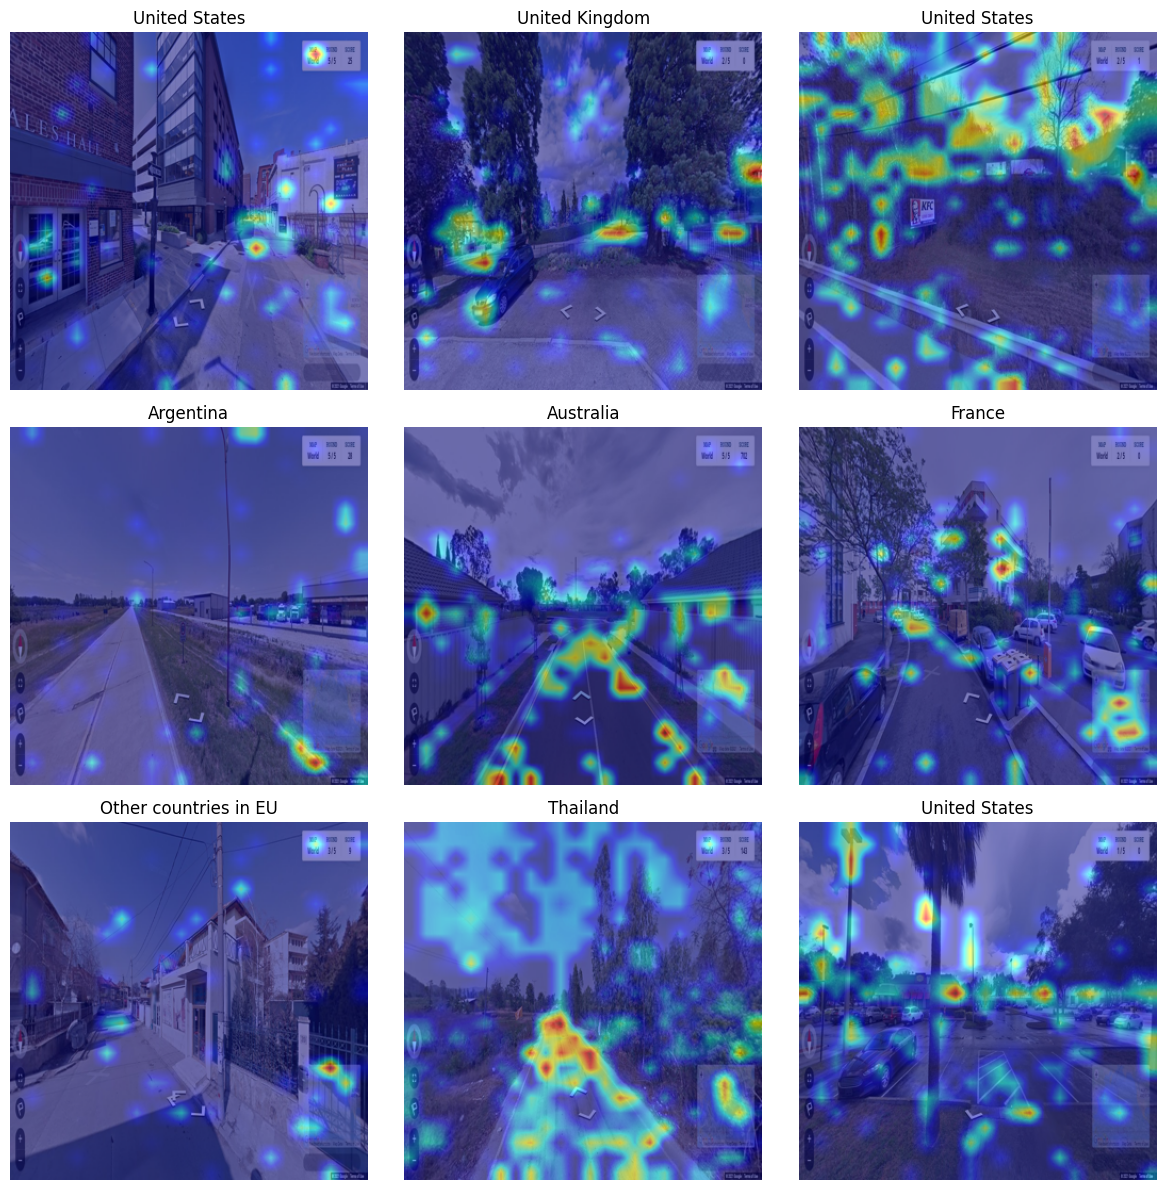

In [25]:
# device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_image_dir = "/root/.cache/kagglehub/datasets/ubitquitin/geolocation-geoguessr-images-50k/versions/1/compressed_dataset"

# load StreetCLIP model + processor
print("loading StreetCLIP for zero-shot inference...")
clip_model = CLIPModel.from_pretrained("geolocal/StreetCLIP").to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained("geolocal/StreetCLIP")
clip_model.eval()  # put model in eval mode

# load train data
train_df = pd.read_csv("train_dataset.csv")
train_df['full_img_path'] = train_df['img_path'].apply(
    lambda x: os.path.join(base_image_dir, x.replace('geoguessr_data/compressed_dataset/', ''))
)
train_not_augmented = train_df[~train_df['img_path'].str.contains('augmented_train')]

# wrapper to compute similarity score for Grad-CAM
class CLIPGradCAMWrapper(torch.nn.Module):
    def __init__(self, clip_model, processor):
        super().__init__()
        self.clip_model = clip_model
        self.processor = processor
        self.text_inputs = None  # store tokenized text prompt

    def set_text_prompt(self, text):
        # preprocess and save text prompt
        self.text_inputs = self.processor(
            text=[text],
            return_tensors="pt",
            padding=True
        ).to(DEVICE)

    def forward(self, pixel_values):
        # Grad-CAM will call this
        if self.text_inputs is None:
            raise ValueError("Text prompt not set. call .set_text_prompt(text) first")
        outputs = self.clip_model(
            pixel_values=pixel_values,
            input_ids=self.text_inputs.input_ids,
            attention_mask=self.text_inputs.attention_mask
        )
        return outputs.logits_per_image  # similarity score

# wrapper to extract ViT pooler_output for Grad-CAM
class VisionModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        outputs = self.model(pixel_values=x)
        return outputs.pooler_output

# setup visual backbone and target layers
visual_model = clip_model.vision_model
wrapped_model = VisionModelWrapper(visual_model).to(DEVICE)
target_layers = [visual_model.encoder.layers[-1].layer_norm1]

# define reshape for ViT feature map
reshape_transform = lambda x: vit_reshape_transform(x, height=24, width=24)

# initialize Grad-CAM wrapper
cam_model = CLIPGradCAMWrapper(clip_model, clip_processor).to(DEVICE)

print("using ViT-compatible reshape transform with 24x24 grid")

# init Grad-CAM
cam = GradCAM(
    model=cam_model,
    target_layers=target_layers,
    reshape_transform=reshape_transform
)
print("GradCAM ready for ViT model")

# preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize((336, 336)),
    transforms.ToTensor()
])

# sample 9 images and visualize
sampled_df = train_not_augmented.sample(9, random_state=123).reset_index(drop=True)
plt.figure(figsize=(12, 12))

for i in range(9):
    img_path = sampled_df.loc[i, 'full_img_path']
    label = sampled_df.loc[i, 'country']
    text_prompt = f"a street view in {label}"

    try:
        img = Image.open(img_path).convert("RGB")
        input_tensor = preprocess(img).unsqueeze(0).to(DEVICE)

        # set text prompt for Grad-CAM
        cam_model.set_text_prompt(text_prompt)

        # targets=None maximizes model output
        grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0, :]

        rgb_img = np.array(img.resize((336, 336))) / 255.0
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        plt.subplot(3, 3, i + 1)
        plt.imshow(visualization)
        plt.title(label)
        plt.axis("off")

    except FileNotFoundError:
        print(f"missing file: {img_path}")
        continue

plt.tight_layout()
plt.show()



## Error Analysis
- Which countries are we predicting better

## Extra Stuff - Probably Not useful

In [ ]:
# F1 Score by Country for StreetLearn Model

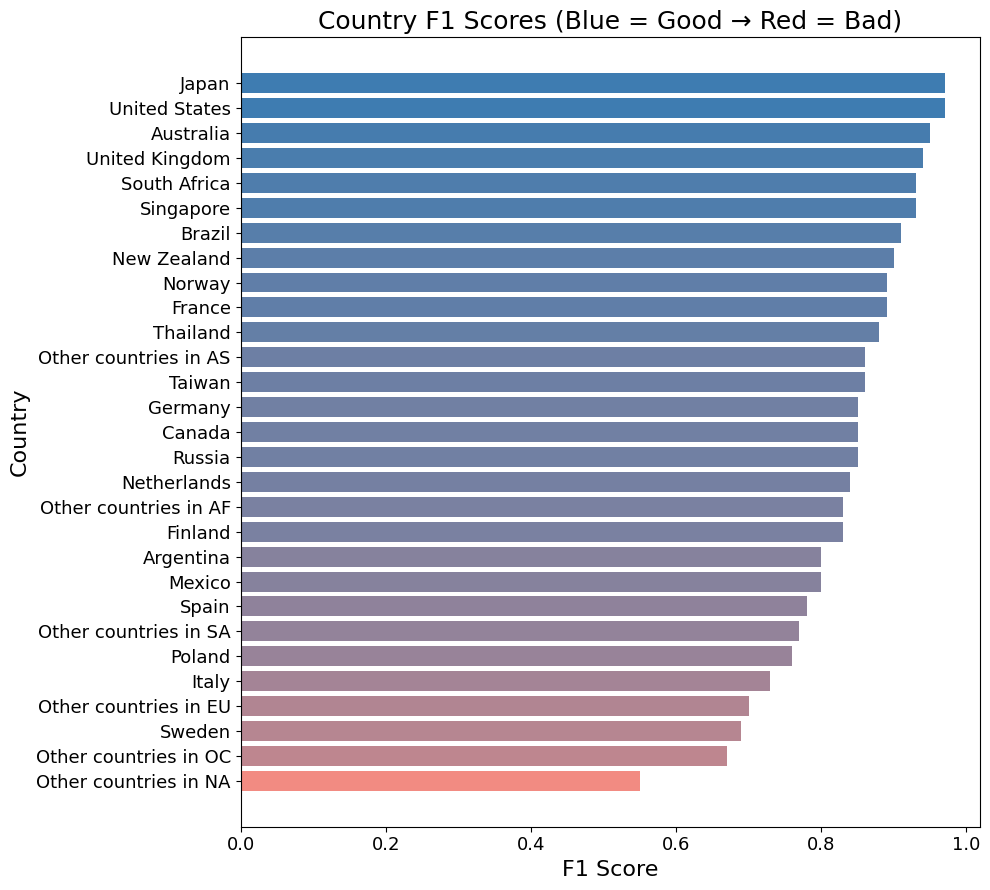

In [ ]:


data = {
    'Country': ['Argentina','Australia','Brazil','Canada','Finland','France','Germany','Italy','Japan','Mexico','Netherlands','New Zealand','Norway','Other countries in AF','Other countries in AS','Other countries in EU','Other countries in NA','Other countries in OC','Other countries in SA','Poland','Russia','Singapore','South Africa','Spain','Sweden','Taiwan','Thailand','United Kingdom','United States'],
    'F1': [0.80,0.95,0.91,0.85,0.83,0.89,0.85,0.73,0.97,0.80,0.84,0.90,0.89,0.83,0.86,0.70,0.55,0.67,0.77,0.76,0.85,0.93,0.93,0.78,0.69,0.86,0.88,0.94,0.97]
}

df = pd.DataFrame(data).sort_values('F1', ascending=False).reset_index(drop=True)

# Normalize scores to 0-1
norm = 1 - ((df['F1'] - df['F1'].min()) / (df['F1'].max() - df['F1'].min()))


# Rice blue to light red gradient
# dark deep blue: #00205B
# light red: #F28B82
colors = []
for n in norm:
    blue = (62,124,177)
    red  = (242,139,130)

    r = int((blue[0]*(1-n)) + (red[0]*n))
    g = int((blue[1]*(1-n)) + (red[1]*n))
    b = int((blue[2]*(1-n)) + (red[2]*n))
    colors.append(f'#{r:02x}{g:02x}{b:02x}')

plt.figure(figsize=(10,9))
plt.barh(df['Country'], df['F1'], color=colors)
plt.gca().invert_yaxis()
plt.xlabel("F1 Score", fontsize=16)
plt.ylabel("Country", fontsize=16)
plt.title("Country F1 Scores (Blue = Good → Red = Bad)", fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()


##